# **Petit Projet 2024 - AIAO**

### *Gabriel Duval*

The aim of this project is to train neural network models on two different datasets: the handwritten MNIST data, slightly modified to be noisier, and the Localization dataset, taken from this [link](https://github.com/JJAlmagro/subcellular_localization). In this notebook, we detail all data manipulation, network training, and network evaluation on these two datasets.

IMPORTANT : All models in this notebook were constructed using Pytorch - please make sure this is installed in your virtual environment. Alternatively, visit this [link](https://github.com/gabriel-dval/mnist_cnns) to be redirected to the github for this project where an environment file is available.

## Dataset 1 : Handwritten MNIST dataset

First, import all necessary modules.

In [2]:
#Import modules

import os
import re
import time
import random
import datetime as dt

import numpy as np
#import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import IterableDataset, DataLoader, Dataset

# TQDM may have problems running in the notebook
from tqdm.autonotebook import tqdm

from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, matthews_corrcoef, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wilcoxon

/var/folders/q0/qr2p81z57ng66y5jc1yz6bwh0000gn/T/ipykernel_15133/3868831144.py:17: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Before training the model or loading the data, several seeds need to be set for reproducibility

In [2]:
def set_seed(seed = 42):
    """Fix the seeds for reproductible runs during training"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


Now, the data can be loaded and some initial analysis can be done. Note that the path to the data may need to be edited depending on your file architecture.

In [3]:
image_path = 'mnist_cnns/data'

X_train = np.load(os.path.join(image_path, 'train_images.npy'))
y_train = np.load(os.path.join(image_path, 'train_labels.npy'))
X_test = np.load(os.path.join(image_path, 'test_images.npy'))
y_test = np.load(os.path.join(image_path, 'test_labels.npy'))

# Check shape to ensure proper loading
print(X_train.shape)  # Expect (60000, 28, 28, 1)
print(y_train.shape)  # Expect (60000,)

(60000, 28, 28, 1)
(60000,)


We can now visualize some of the MNIST images.

In [4]:
%matplotlib inline

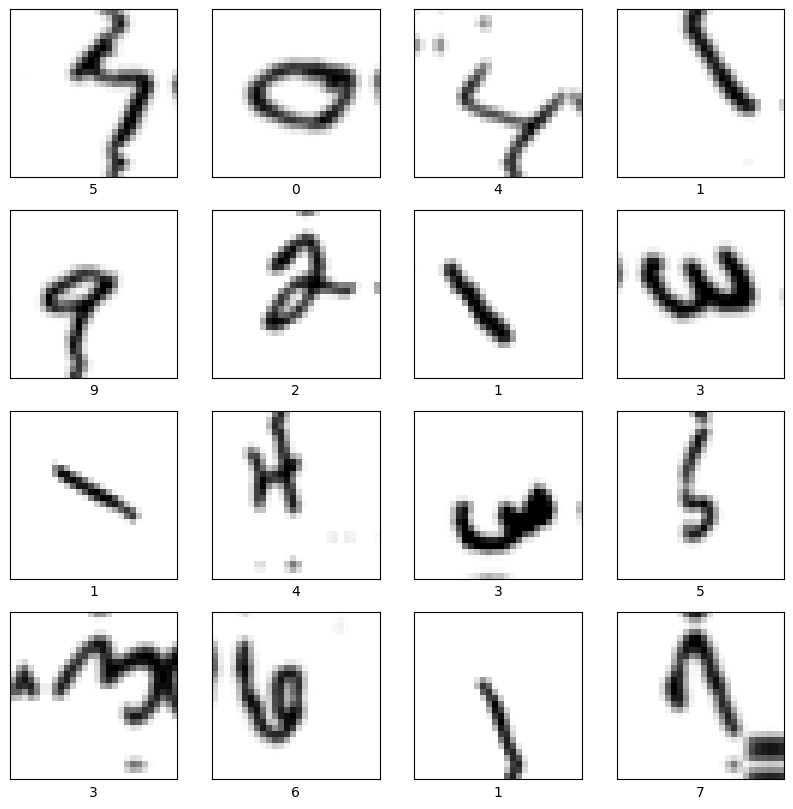

In [5]:
def view_images(X_images, y_labels):
    '''Function to view 16 images provided using matplotlib

    Args
    ---
    X_images : array
        Images
    y_labels : array
        Labels

    Returns
    ---
    Nothing
    '''
    # Display images using matplotlib
    plt.figure(figsize=[10,10])
    for i in range (16):    # for first 16 images
        plt.subplot(4, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_images[i], cmap=plt.cm.binary)
        plt.xlabel(y_labels[i])

    plt.show()


view_images(X_train, y_train)

There are 10 possible handwritten digits, hence 10 possible classes. To make sure this dataset is representative, we can check the counts of each class in the training and test set using a simple histogram.

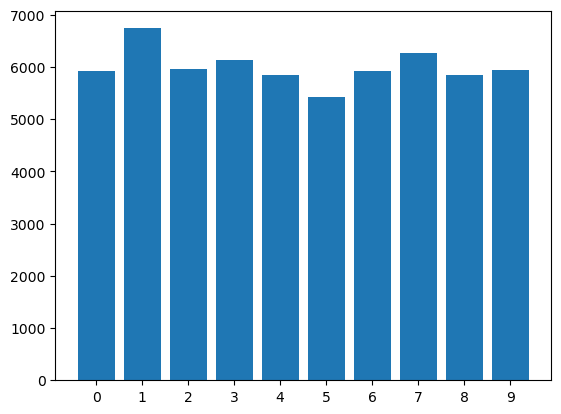

In [6]:
# Counts in training set

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], counts)
plt.show()

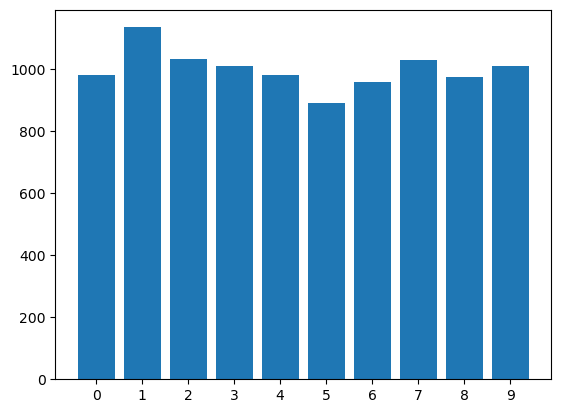

In [7]:
# Counts in test set

unique, counts = np.unique(y_test, return_counts=True)
plt.bar(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], counts)
plt.show()

Luckily, the counts look fairly homogenous for all classes.

The data can now be split in train, validation and test sets. As the test set has also been provided, all that must be done is split the training set into a train and validation. 

In [8]:
def train_validation_test(X_train, y_train, X_test, y_test, val_proportion = 0.125):
    '''Simple function to create our train, validation and test sets
    Based on previously handed out format of data.
    
    Args
    ---
    X_train : array
    y_train : array
    X_test : array
    y_test : array
    val_proportion : float

    Returns
    ---
    X_tr : array
    y_tr : array
    X_val : array
    y_val : array
    X_test : array
    y_test : array
    '''
    # Shuffle train data set and test data set
    ns =  X_train.shape[0]
    shuffle_index = np.random.permutation(ns)
    train_images, train_labels = X_train[shuffle_index,:,:,:], y_train[shuffle_index]

    ns =  X_test.shape[0]
    shuffle_index = np.random.permutation(ns)
    test_images, test_labels = X_test[shuffle_index,:,:,:], y_test[shuffle_index]

    # Set validation index
    val_size = int(ns * val_proportion)

    # Create train, test and validaiton - test data must also be normalized
    X_tr = train_images[:-val_size,:,:,:]
    y_tr = train_labels[:-val_size]
    X_val = train_images[-val_size:,:,:,:]
    y_val = train_labels[-val_size:]
    X_te = test_images / 255
    y_te = test_labels
    
    return X_tr, y_tr, X_val, y_val, X_te, y_te


tx, ty, vx, vy, tex, tey = train_validation_test(X_train, y_train, X_test, y_test)

We can now start to build our models. First, we shall build a simple neural network composed only of fully connected (FC) layers.

### Model 1 - Fully Connected Network

Preparing the data for training needs to be done through a modified descendant of the Dataset class

In [9]:
def prep_flat_image(X, y):
    '''Function to prepare image for training

    Args
    ---
    X : array
        2D image 
    y : array
        Associated label
    '''
    # Flatten image and turn into tensor
    pixels = 28 * 28 # Image dimensions
    flat_X = X.reshape(pixels)
    tensor_X = torch.from_numpy(flat_X.astype(np.float32))

    # Turn label into class vector
    tensor_y = torch.as_tensor(y, dtype = torch.long)
    oh_y = nn.functional.one_hot(tensor_y, num_classes = 10)
    oh_y = oh_y.to(torch.float32)
    
    # Return image and label
    return tensor_X, oh_y

In [10]:
class MNISTCustom(Dataset):
    '''Custom dataset for processing the MNIST images'''
    def __init__(self, X_path, y_path):
        self.X_path = X_path  # X
        self.y_path = y_path  # Y
    
    def __len__(self):
        return len(self.y_path)
    
    def __getitem__(self, idx):
        image = self.X_path[idx, :, :, :]
        label = self.y_path[idx]
        return prep_flat_image(image, label)

Now we can define the train, validation and test functions, which underlie the actual training process of the network.

In [11]:
def train(model, train_loader, loss_fn, optimizer, epoch):
    '''Train function for the model. To evaluate the training, multiple different
    measures are used: Balanced Accuracy, Precision, Recall.

    Arguments
    ---
    model : nn.Module descendant
        Model through which training data is passed
    train_loader : DataLoader
        Training data with features and labels
    loss_fn : function
        Method of loss calculation
    optimizer : function (taken using torch.optim)
        Optimisation method
    epoch : int
        Number of passes through the network

    Returns
    ---
    epoch_loss : ?
        Information on loss (loss vector ?)
    '''
    model.train()

    train_loss = 0
    counter = 0

    confusion_matrices = []

    all_true_classes = []
    all_pred_classes = []

    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    with tqdm(train_loader, total=len(train_loader), unit="batch") as tepoch:
        for X, y in tepoch:
            counter += 1
            tepoch.set_description(f"Epoch {epoch}")

            #Send the input to the device
            X, y = X.to(device), y.to(device)

            #Compute prediction and loss
            pred = model(X)

            # Loss calculation
            loss = torch.sum(loss_fn(pred, y))

            #Backpropagation
            optimizer.zero_grad(set_to_none = True)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        
            # Batch metrics - first detach vectors
            pred = pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            class_preds = np.argmax(pred, axis = 1)
            true = np.argmax(y, axis = 1)

            # Save class information     
            all_true_classes.extend(true)
            all_pred_classes.extend(class_preds)
           
            #Progres pbar
            postfix = {}
            postfix["Train: loss"] = f"{train_loss / counter:.5f}"
            tepoch.set_postfix(postfix)
        
        #Loss and protein metrics
        epoch_loss = train_loss / counter

        # overall_conf_matrix = confusion_matrix(all_true_classes, all_pred_classes)
        # overall_performance = classification_report(all_true_classes, all_pred_classes, 
        #                                             target_names = labels, zero_division=0.0)
        ba = balanced_accuracy_score(all_true_classes, all_pred_classes)
        mc = matthews_corrcoef(all_true_classes, all_pred_classes)


        #Prints
        print(f"\n Training performance across images : \n")
        print(f"Balanced Accuracy Score : {ba}")
        print(f"Matthews CC : {mc}")
    
    return epoch_loss

In [12]:
def validate(model, val_loader, loss_fn, epoch):
    '''Train function for the model. 

    Arguments
    ---
    model : nn.Module descendant
        Model through which training data is passed
    val_loader : DataLoader
        Validation data with features and labels
    loss_fn : function
        Method of loss calculation
    optimizer : function (taken using torch.optim)
        Optimisation method
    epoch : int
        Number of passes through the network

    Returns
    ---
    epoch_loss : ?
        Information on loss (loss vector ?)
    '''
    model.eval()

    val_loss = 0
    counter = 0

    confusion_matrices = []

    all_true_classes = []
    all_pred_classes = []

    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    with torch.no_grad():
        for X, y in val_loader:
            counter += 1

            #Send the input to the device
            X, y = X.to(device), y.to(device)

            #Compute prediction and loss
            pred = model(X)

            # Loss calculation
            loss = torch.sum(loss_fn(pred, y))
            val_loss += loss.item()
        
            # Batch metrics - first detach vectors
            pred = pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            class_preds = np.argmax(pred, axis = 1)
            true = np.argmax(y, axis = 1)

            # Save class information     
            all_true_classes.extend(true)
            all_pred_classes.extend(class_preds)
        
        #Loss and protein metrics
        epoch_loss = val_loss / counter

        # overall_conf_matrix = confusion_matrix(all_true_classes, all_pred_classes)
        # overall_performance = classification_report(all_true_classes, all_pred_classes, 
        #                                             target_names = labels, zero_division=0.0)
        ba = balanced_accuracy_score(all_true_classes, all_pred_classes)
        mc = matthews_corrcoef(all_true_classes, all_pred_classes)
    
        

        #Prints
        print(f"\n Validation performance across images : \n")
        print(f"Balanced Accuracy Score : {ba}")
        print(f"Matthews CC : {mc}")
        
    return epoch_loss

In [13]:
def test(model, test_loader, loss_fn, epoch, figure_path):
    '''Train function for the model. 

    Arguments
    ---
    model : nn.Module descendant
        Model through which training data is passed
    val_loader : DataLoader
        Validation data with features and labels
    loss_fn : function
        Method of loss calculation
    optimizer : function (taken using torch.optim)
        Optimisation method
    epoch : int
        Number of passes through the network

    Returns
    ---
    epoch_loss : ?
        Information on loss (loss vector ?)
    '''
    model.eval()

    test_loss = 0
    counter = 0

    all_true_classes = []
    all_pred_classes = []

    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    with torch.no_grad():
        for X, y in test_loader:
            counter += 1

            #Send the input to the device
            X, y = X.to(device), y.to(device)

            #Compute prediction and loss
            pred = model(X)

            # Loss calculation
            loss = torch.sum(loss_fn(pred, y))
            test_loss += loss.item()
        
            # Batch metrics - first detach vectors
            pred = pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            class_preds = np.argmax(pred, axis = 1)
            true = np.argmax(y, axis = 1)

            # Save class information     
            all_true_classes.extend(true)
            all_pred_classes.extend(class_preds)
        
        #Loss and protein metrics
        epoch_loss = test_loss / counter

        overall_conf_matrix = confusion_matrix(all_true_classes, all_pred_classes, normalize='true')
        # overall_performance = classification_report(all_true_classes, all_pred_classes, 
        #                                             target_names = labels, zero_division=0.0)
        ba = balanced_accuracy_score(all_true_classes, all_pred_classes)
        mc = matthews_corrcoef(all_true_classes, all_pred_classes)

        
        #Prints
        print(f"\n Test performance across images : \n")
        print(f"Balanced Accuracy Score : {ba}")
        print(f"Matthews CC : {mc}")
    
    return epoch_loss, all_pred_classes, all_true_classes

Now that these functions are defined, we can organise the basic architecture of our model

In [14]:
class Base(nn.Module):

    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
        self.softmax = torch.nn.Softmax(dim = 1)

    def forward(self, x):
        
        out = self.stack(x)
        out = self.softmax(out)

        return out

We can also check the number of trainable parameters that this model has.

In [15]:
model = Base()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

235146

One last thing to add is an early stopping function, to stop the training if the validation loss does not improve after a certain amount of epochs (known as the patience).

In [16]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=10, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"[INFO]: Early stopping counter - {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('[INFO]: Early stopping')
                self.early_stop = True

Now put all these elements together in a fit function

In [17]:
def fit(epochs, X_train, y_train, X_val, y_val, X_test, y_test, loss_fn, save_loc, early_stopping = True):
    '''Function to load data and fit model for a set number of epochs

    Arguments
    ---
    epochs : int
        Number of passes through network
    X_train : array
    y_train : array
    X_val : array
    y_val : array
    X_test : array
    y_test : array
    loss_fn : function
        Loss function to be computed
    save_loc : str
        Where should the results be saved ?
    early_stopping : boolean
        Using early stopping ?

    Returns
    ---
    loss_vector : list
        Training loss values for each epoch
    val_loss_vector : list
        Validation loss values for each epoch
    predictions : list
        Predicted classes of image
    real_vals : list
        True classes of image
    '''
    start = time.time()

    # Initialise patience
    if early_stopping:
        print("[INFO]: Initializing early stopping")
        early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0)


    # Create test set.
    loss_vector = []
    val_loss_vector = []
    

    test_dataset = MNISTCustom(X_test, y_test)
    t_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    
    model = Base().to(device)

    # Set optimizer based on model parameters
    lr = LR
    optimizer = optim.RMSprop(model.parameters(), 
                        lr=lr) 

    # Train model for set number of epochs
    for epoch in range(epochs):
        #Create the datasets and dataloaders for training with shuffle each step
        train_data = MNISTCustom(X_train, y_train)
        val_data = MNISTCustom(X_val, y_val)
        train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
        val_loss = validate(model, val_loader, loss_fn, epoch)
        loss_vector.append(train_loss)
        val_loss_vector.append(val_loss)

        if early_stopping:
            early_stopping(val_loss)
            if early_stopping.early_stop:
                break

    test_loss, predictions, real_vals = test(model, t_loader, loss_fn, epochs, '../results')

    # Save weights of each model
    # model_name = f'{path[29:]}_{CURRENT_CV}'
    # save_model(epochs, model, optimizer, loss_fn, save_loc, model_name)
    
    end = time.time()
    
    print(f"Training time: {(end-start)/60:.3f} minutes\n")
    # print(len(predictions_across_embds))
    print("Model complete")
    return loss_vector, val_loss_vector, predictions, real_vals

After setting a few hyperparameters, we can now train this first model. As the architecture of the model was imposed, a grid-search approach was used to find the best learning rate (LR) /batch size (BS) combination. Due to the implementation of an Early Stopping mechanism, the number of epochs was fixed at 60 and not further optimised. The table below summarises the results of this process  

![Grid Search Table](gridsearch.png)

Boxes highlighed in purple symbolize network trainings that were stopped manually, due to a lack of progress in either training or validation accuracy for 15 epochs.

The code below trains the model using the best parameters found

In [18]:
# Computation device
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {device}\n")

# Set hyperparameters
PATIENCE = 5
BATCH_SIZE = 128
NUM_WORKERS = 0
EPOCHS = 60
LR = 0.001
LOSS_FN = nn.CrossEntropyLoss(reduction = 'none')

loss_vector, val_loss_vector, preds, true = fit(EPOCHS, tx, ty, vx, vy, tex, tey, 
                                                LOSS_FN, None, early_stopping = True)

Computation device: cpu

[INFO]: Initializing early stopping


Epoch 0: 100%|█████████████████████████████████████████████| 459/459 [00:02<00:00, 192.66batch/s, Train: loss=269.47656]



 Training performance across images : 

Balanced Accuracy Score : 0.34979917077570066
Matthews CC : 0.2910637741644208

 Validation performance across images : 

Balanced Accuracy Score : 0.47967538451364417
Matthews CC : 0.44755993215390677


Epoch 1: 100%|█████████████████████████████████████████████| 459/459 [00:02<00:00, 211.98batch/s, Train: loss=250.85293]



 Training performance across images : 

Balanced Accuracy Score : 0.5010476100203178
Matthews CC : 0.4597705582227041

 Validation performance across images : 

Balanced Accuracy Score : 0.552620175636535
Matthews CC : 0.5268482763819755


Epoch 2: 100%|█████████████████████████████████████████████| 459/459 [00:02<00:00, 200.67batch/s, Train: loss=244.17154]



 Training performance across images : 

Balanced Accuracy Score : 0.5508591302664567
Matthews CC : 0.5134609387025303

 Validation performance across images : 

Balanced Accuracy Score : 0.5857426638358547
Matthews CC : 0.5607313711867874


Epoch 3: 100%|█████████████████████████████████████████████| 459/459 [00:02<00:00, 183.66batch/s, Train: loss=239.95321]



 Training performance across images : 

Balanced Accuracy Score : 0.5846592092742984
Matthews CC : 0.5504450142610304

 Validation performance across images : 

Balanced Accuracy Score : 0.6298343825527978
Matthews CC : 0.6044636455797983


Epoch 4: 100%|█████████████████████████████████████████████| 459/459 [00:02<00:00, 195.56batch/s, Train: loss=237.43444]



 Training performance across images : 

Balanced Accuracy Score : 0.602923165266838
Matthews CC : 0.5702435503965915

 Validation performance across images : 

Balanced Accuracy Score : 0.6447562495840662
Matthews CC : 0.6208224077156028


Epoch 5: 100%|█████████████████████████████████████████████| 459/459 [00:02<00:00, 198.09batch/s, Train: loss=235.06182]



 Training performance across images : 

Balanced Accuracy Score : 0.6217895344996868
Matthews CC : 0.5909209692575406

 Validation performance across images : 

Balanced Accuracy Score : 0.6514220935197088
Matthews CC : 0.6270299324993044


Epoch 6: 100%|█████████████████████████████████████████████| 459/459 [00:02<00:00, 202.27batch/s, Train: loss=233.48576]



 Training performance across images : 

Balanced Accuracy Score : 0.6335379333689269
Matthews CC : 0.60375526114784

 Validation performance across images : 

Balanced Accuracy Score : 0.6510065120280981
Matthews CC : 0.6303942882722833


Epoch 7: 100%|█████████████████████████████████████████████| 459/459 [00:02<00:00, 194.99batch/s, Train: loss=232.42316]



 Training performance across images : 

Balanced Accuracy Score : 0.6412665712479773
Matthews CC : 0.6120005768789633

 Validation performance across images : 

Balanced Accuracy Score : 0.6580356529199938
Matthews CC : 0.6367012128531546


Epoch 8: 100%|█████████████████████████████████████████████| 459/459 [00:02<00:00, 178.44batch/s, Train: loss=231.15868]



 Training performance across images : 

Balanced Accuracy Score : 0.6513548190727902
Matthews CC : 0.6229633778417337

 Validation performance across images : 

Balanced Accuracy Score : 0.6716907674837025
Matthews CC : 0.6497943652832919


Epoch 9: 100%|█████████████████████████████████████████████| 459/459 [00:02<00:00, 191.24batch/s, Train: loss=229.92598]



 Training performance across images : 

Balanced Accuracy Score : 0.6612894097877245
Matthews CC : 0.633935623812412

 Validation performance across images : 

Balanced Accuracy Score : 0.6814134338248063
Matthews CC : 0.6616355798422492


Epoch 10: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 186.46batch/s, Train: loss=229.06547]



 Training performance across images : 

Balanced Accuracy Score : 0.6674367068814895
Matthews CC : 0.6407388209984072

 Validation performance across images : 

Balanced Accuracy Score : 0.6969174236553262
Matthews CC : 0.6774321189546213


Epoch 11: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 195.89batch/s, Train: loss=228.19239]



 Training performance across images : 

Balanced Accuracy Score : 0.6745957910140683
Matthews CC : 0.648498172993119

 Validation performance across images : 

Balanced Accuracy Score : 0.6923382086919686
Matthews CC : 0.6723972739496308


Epoch 12: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 175.04batch/s, Train: loss=227.44986]



 Training performance across images : 

Balanced Accuracy Score : 0.680676043138259
Matthews CC : 0.6551872251251541

 Validation performance across images : 

Balanced Accuracy Score : 0.7091059287947412
Matthews CC : 0.6883432860882531


Epoch 13: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 189.22batch/s, Train: loss=226.43766]



 Training performance across images : 

Balanced Accuracy Score : 0.6883651513259067
Matthews CC : 0.6637741449788673

 Validation performance across images : 

Balanced Accuracy Score : 0.6991506025289735
Matthews CC : 0.6795505314614201
[INFO]: Early stopping counter - 1 of 5


Epoch 14: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 191.71batch/s, Train: loss=225.88760]



 Training performance across images : 

Balanced Accuracy Score : 0.6926295726404307
Matthews CC : 0.6684163602235176

 Validation performance across images : 

Balanced Accuracy Score : 0.7109018445077422
Matthews CC : 0.6940079488230487


Epoch 15: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 185.42batch/s, Train: loss=225.26388]



 Training performance across images : 

Balanced Accuracy Score : 0.6979203256970087
Matthews CC : 0.6741641458124499

 Validation performance across images : 

Balanced Accuracy Score : 0.7137813534530527
Matthews CC : 0.692916005945464
[INFO]: Early stopping counter - 1 of 5


Epoch 16: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 188.84batch/s, Train: loss=224.67287]



 Training performance across images : 

Balanced Accuracy Score : 0.7025168476711563
Matthews CC : 0.6792638049960683

 Validation performance across images : 

Balanced Accuracy Score : 0.716752550009174
Matthews CC : 0.6994872150878316


Epoch 17: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 189.73batch/s, Train: loss=224.24077]



 Training performance across images : 

Balanced Accuracy Score : 0.7057127427244128
Matthews CC : 0.6826520442887277

 Validation performance across images : 

Balanced Accuracy Score : 0.7286710800713863
Matthews CC : 0.7104117039283343


Epoch 18: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 184.84batch/s, Train: loss=223.66154]



 Training performance across images : 

Balanced Accuracy Score : 0.7107223215205717
Matthews CC : 0.6882004937580041

 Validation performance across images : 

Balanced Accuracy Score : 0.7172295071407107
Matthews CC : 0.6977676216526523
[INFO]: Early stopping counter - 1 of 5


Epoch 19: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 188.76batch/s, Train: loss=223.45390]



 Training performance across images : 

Balanced Accuracy Score : 0.7127605567724882
Matthews CC : 0.6903286441489334

 Validation performance across images : 

Balanced Accuracy Score : 0.7280381169725315
Matthews CC : 0.7097114257069439


Epoch 20: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 183.53batch/s, Train: loss=222.85821]



 Training performance across images : 

Balanced Accuracy Score : 0.7164210157335615
Matthews CC : 0.6944466566644139

 Validation performance across images : 

Balanced Accuracy Score : 0.7274070797894835
Matthews CC : 0.7080460236075997
[INFO]: Early stopping counter - 1 of 5


Epoch 21: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 180.87batch/s, Train: loss=222.34001]



 Training performance across images : 

Balanced Accuracy Score : 0.7204990555377118
Matthews CC : 0.6990546308240408

 Validation performance across images : 

Balanced Accuracy Score : 0.7345058991937614
Matthews CC : 0.7167215988224479


Epoch 22: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 182.52batch/s, Train: loss=221.95436]



 Training performance across images : 

Balanced Accuracy Score : 0.7235640565821682
Matthews CC : 0.7023321032940573

 Validation performance across images : 

Balanced Accuracy Score : 0.7284154515172575
Matthews CC : 0.7092600980778617
[INFO]: Early stopping counter - 1 of 5


Epoch 23: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 182.88batch/s, Train: loss=221.91838]



 Training performance across images : 

Balanced Accuracy Score : 0.7237933661193793
Matthews CC : 0.7025738174862389

 Validation performance across images : 

Balanced Accuracy Score : 0.7411170228877659
Matthews CC : 0.7230534537456725


Epoch 24: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 175.07batch/s, Train: loss=221.50849]



 Training performance across images : 

Balanced Accuracy Score : 0.7263899388667712
Matthews CC : 0.7055122997182878

 Validation performance across images : 

Balanced Accuracy Score : 0.7356259108452421
Matthews CC : 0.7182253741995757
[INFO]: Early stopping counter - 1 of 5


Epoch 25: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 196.13batch/s, Train: loss=221.11504]



 Training performance across images : 

Balanced Accuracy Score : 0.7295187919699886
Matthews CC : 0.7088522604426455

 Validation performance across images : 

Balanced Accuracy Score : 0.745875561281253
Matthews CC : 0.7285256303027375


Epoch 26: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 168.25batch/s, Train: loss=220.72259]



 Training performance across images : 

Balanced Accuracy Score : 0.7329544703707603
Matthews CC : 0.7127243523963173

 Validation performance across images : 

Balanced Accuracy Score : 0.7396094777988592
Matthews CC : 0.7227509162741768
[INFO]: Early stopping counter - 1 of 5


Epoch 27: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 156.38batch/s, Train: loss=220.76164]



 Training performance across images : 

Balanced Accuracy Score : 0.7326746259053374
Matthews CC : 0.7122904966893979

 Validation performance across images : 

Balanced Accuracy Score : 0.7372125975717453
Matthews CC : 0.7195423649824599
[INFO]: Early stopping counter - 2 of 5


Epoch 28: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 167.87batch/s, Train: loss=220.20682]



 Training performance across images : 

Balanced Accuracy Score : 0.7372676399606974
Matthews CC : 0.717429475205187

 Validation performance across images : 

Balanced Accuracy Score : 0.7383735732374846
Matthews CC : 0.7220790771800818
[INFO]: Early stopping counter - 3 of 5


Epoch 29: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 168.16batch/s, Train: loss=220.16171]



 Training performance across images : 

Balanced Accuracy Score : 0.7367816254083409
Matthews CC : 0.7169244588021807

 Validation performance across images : 

Balanced Accuracy Score : 0.7360206827996052
Matthews CC : 0.7176283978716425
[INFO]: Early stopping counter - 4 of 5


Epoch 30: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 171.14batch/s, Train: loss=219.85688]



 Training performance across images : 

Balanced Accuracy Score : 0.7403824924807135
Matthews CC : 0.7206796351353112

 Validation performance across images : 

Balanced Accuracy Score : 0.7358172842171642
Matthews CC : 0.7192650866654904


Epoch 31: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 168.82batch/s, Train: loss=219.66798]



 Training performance across images : 

Balanced Accuracy Score : 0.7411733649493614
Matthews CC : 0.7216911311439888

 Validation performance across images : 

Balanced Accuracy Score : 0.7489721454735937
Matthews CC : 0.7318142141151353


Epoch 32: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 167.30batch/s, Train: loss=219.46182]



 Training performance across images : 

Balanced Accuracy Score : 0.7429838077425532
Matthews CC : 0.7237858157196098

 Validation performance across images : 

Balanced Accuracy Score : 0.7401120189062312
Matthews CC : 0.7221124898711591
[INFO]: Early stopping counter - 1 of 5


Epoch 33: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 169.56batch/s, Train: loss=219.45399]



 Training performance across images : 

Balanced Accuracy Score : 0.7424998720418718
Matthews CC : 0.7231639749185798

 Validation performance across images : 

Balanced Accuracy Score : 0.7518073250622798
Matthews CC : 0.7352081156931725
[INFO]: Early stopping counter - 2 of 5


Epoch 34: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 164.28batch/s, Train: loss=219.03273]



 Training performance across images : 

Balanced Accuracy Score : 0.7459393621987896
Matthews CC : 0.7269333918548117

 Validation performance across images : 

Balanced Accuracy Score : 0.7492395114740019
Matthews CC : 0.7326560108552181
[INFO]: Early stopping counter - 3 of 5


Epoch 35: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 164.23batch/s, Train: loss=218.76434]



 Training performance across images : 

Balanced Accuracy Score : 0.7486036976171209
Matthews CC : 0.7299400952081275

 Validation performance across images : 

Balanced Accuracy Score : 0.7458023394623944
Matthews CC : 0.7289743831018475
[INFO]: Early stopping counter - 4 of 5


Epoch 36: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 163.16batch/s, Train: loss=218.43685]



 Training performance across images : 

Balanced Accuracy Score : 0.7507782685672373
Matthews CC : 0.7315885716360266

 Validation performance across images : 

Balanced Accuracy Score : 0.7627230488124351
Matthews CC : 0.7477246950726617


Epoch 37: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 165.85batch/s, Train: loss=215.54309]



 Training performance across images : 

Balanced Accuracy Score : 0.7749180180292992
Matthews CC : 0.7543206256211864

 Validation performance across images : 

Balanced Accuracy Score : 0.7956153505814569
Matthews CC : 0.7797382956134521


Epoch 38: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 163.84batch/s, Train: loss=214.55672]



 Training performance across images : 

Balanced Accuracy Score : 0.782138073626756
Matthews CC : 0.7616808016560742

 Validation performance across images : 

Balanced Accuracy Score : 0.8074940316989757
Matthews CC : 0.7948137264814337


Epoch 39: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 165.02batch/s, Train: loss=213.60405]



 Training performance across images : 

Balanced Accuracy Score : 0.7907170508844683
Matthews CC : 0.7711316135708877

 Validation performance across images : 

Balanced Accuracy Score : 0.8026319072753282
Matthews CC : 0.7893597464295952


Epoch 40: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 167.39batch/s, Train: loss=212.84848]



 Training performance across images : 

Balanced Accuracy Score : 0.7964052570923361
Matthews CC : 0.777258788221626

 Validation performance across images : 

Balanced Accuracy Score : 0.8129065243687268
Matthews CC : 0.7990363713806157


Epoch 41: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 164.06batch/s, Train: loss=212.60819]



 Training performance across images : 

Balanced Accuracy Score : 0.79839397865862
Matthews CC : 0.7792461453839156

 Validation performance across images : 

Balanced Accuracy Score : 0.8108848761006164
Matthews CC : 0.7967122955860256
[INFO]: Early stopping counter - 1 of 5


Epoch 42: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 153.78batch/s, Train: loss=212.19960]



 Training performance across images : 

Balanced Accuracy Score : 0.8024107800358425
Matthews CC : 0.7836203806390482

 Validation performance across images : 

Balanced Accuracy Score : 0.8123138274694742
Matthews CC : 0.797469886498557
[INFO]: Early stopping counter - 2 of 5


Epoch 43: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 165.87batch/s, Train: loss=212.19672]



 Training performance across images : 

Balanced Accuracy Score : 0.8012091676791325
Matthews CC : 0.7823202972313104

 Validation performance across images : 

Balanced Accuracy Score : 0.8071728472768518
Matthews CC : 0.7928494370457498
[INFO]: Early stopping counter - 3 of 5


Epoch 44: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 166.04batch/s, Train: loss=211.52609]



 Training performance across images : 

Balanced Accuracy Score : 0.8073718225907015
Matthews CC : 0.7891333407178511

 Validation performance across images : 

Balanced Accuracy Score : 0.815366288206309
Matthews CC : 0.8001882258889713


Epoch 45: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 163.85batch/s, Train: loss=211.30542]



 Training performance across images : 

Balanced Accuracy Score : 0.8091153354179216
Matthews CC : 0.7909394656797025

 Validation performance across images : 

Balanced Accuracy Score : 0.8267550208238237
Matthews CC : 0.8142217283642498


Epoch 46: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 166.18batch/s, Train: loss=211.01053]



 Training performance across images : 

Balanced Accuracy Score : 0.8108763588898895
Matthews CC : 0.7928827576538182

 Validation performance across images : 

Balanced Accuracy Score : 0.8300558056731141
Matthews CC : 0.8160688712043548
[INFO]: Early stopping counter - 1 of 5


Epoch 47: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 164.05batch/s, Train: loss=210.91709]



 Training performance across images : 

Balanced Accuracy Score : 0.812415747819108
Matthews CC : 0.7945082460377004

 Validation performance across images : 

Balanced Accuracy Score : 0.8312301457140296
Matthews CC : 0.818646525667105


Epoch 48: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 154.50batch/s, Train: loss=210.84734]



 Training performance across images : 

Balanced Accuracy Score : 0.8122179217574239
Matthews CC : 0.7944088672395132

 Validation performance across images : 

Balanced Accuracy Score : 0.8307981893869357
Matthews CC : 0.8176964996818724


Epoch 49: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 167.39batch/s, Train: loss=210.41299]



 Training performance across images : 

Balanced Accuracy Score : 0.8160195973844344
Matthews CC : 0.7984662316916474

 Validation performance across images : 

Balanced Accuracy Score : 0.8322282940293844
Matthews CC : 0.8186066604389818
[INFO]: Early stopping counter - 1 of 5


Epoch 50: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 163.40batch/s, Train: loss=210.09777]



 Training performance across images : 

Balanced Accuracy Score : 0.8182311712208014
Matthews CC : 0.8009164531561637

 Validation performance across images : 

Balanced Accuracy Score : 0.8322395243170966
Matthews CC : 0.8204294747662726


Epoch 51: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 163.98batch/s, Train: loss=210.23301]



 Training performance across images : 

Balanced Accuracy Score : 0.8175304439808702
Matthews CC : 0.7999055181260396

 Validation performance across images : 

Balanced Accuracy Score : 0.8299761310151264
Matthews CC : 0.8167799924113388
[INFO]: Early stopping counter - 1 of 5


Epoch 52: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 167.06batch/s, Train: loss=209.88623]



 Training performance across images : 

Balanced Accuracy Score : 0.819536936555801
Matthews CC : 0.8023091324498143

 Validation performance across images : 

Balanced Accuracy Score : 0.8251256190861541
Matthews CC : 0.8133688869593497
[INFO]: Early stopping counter - 2 of 5


Epoch 53: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 170.10batch/s, Train: loss=209.68823]



 Training performance across images : 

Balanced Accuracy Score : 0.8214394583857938
Matthews CC : 0.8043171235659249

 Validation performance across images : 

Balanced Accuracy Score : 0.8349437367732501
Matthews CC : 0.822164881656769


Epoch 54: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 173.05batch/s, Train: loss=209.30326]



 Training performance across images : 

Balanced Accuracy Score : 0.8242611002968824
Matthews CC : 0.8074800470309466

 Validation performance across images : 

Balanced Accuracy Score : 0.825457130360826
Matthews CC : 0.811628113601499
[INFO]: Early stopping counter - 1 of 5


Epoch 55: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 171.20batch/s, Train: loss=209.43545]



 Training performance across images : 

Balanced Accuracy Score : 0.8232920846648273
Matthews CC : 0.8064047447246484

 Validation performance across images : 

Balanced Accuracy Score : 0.8144610036495947
Matthews CC : 0.8022088424698479
[INFO]: Early stopping counter - 2 of 5


Epoch 56: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 167.95batch/s, Train: loss=209.07100]



 Training performance across images : 

Balanced Accuracy Score : 0.82586851598293
Matthews CC : 0.8092208279635398

 Validation performance across images : 

Balanced Accuracy Score : 0.8320533961851388
Matthews CC : 0.8205963036393764
[INFO]: Early stopping counter - 3 of 5


Epoch 57: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 169.56batch/s, Train: loss=208.91686]



 Training performance across images : 

Balanced Accuracy Score : 0.8273883859369772
Matthews CC : 0.810814314055454

 Validation performance across images : 

Balanced Accuracy Score : 0.8420558037108712
Matthews CC : 0.829637491631494


Epoch 58: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 170.58batch/s, Train: loss=208.80244]



 Training performance across images : 

Balanced Accuracy Score : 0.8279457028619259
Matthews CC : 0.8114880744318403

 Validation performance across images : 

Balanced Accuracy Score : 0.8333367965840056
Matthews CC : 0.8204482363972795
[INFO]: Early stopping counter - 1 of 5


Epoch 59: 100%|████████████████████████████████████████████| 459/459 [00:02<00:00, 171.37batch/s, Train: loss=208.53291]



 Training performance across images : 

Balanced Accuracy Score : 0.830300250343883
Matthews CC : 0.8141077618071959

 Validation performance across images : 

Balanced Accuracy Score : 0.8238897941372996
Matthews CC : 0.8098910821217644
[INFO]: Early stopping counter - 2 of 5

 Test performance across images : 

Balanced Accuracy Score : 0.8470819978334723
Matthews CC : 0.8335887638940495
Training time: 2.694 minutes

Model complete


We can now analyse some of the results of this network. Shown below are the loss and validation functions, as well as the confidence matrix of predictions.

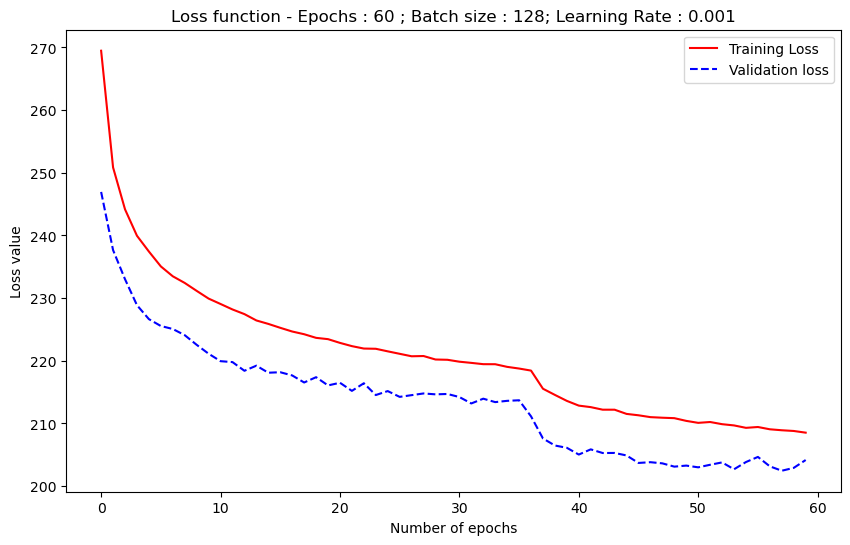

In [19]:
def plot_loss_function(loss_vector, val_loss_vector):
    '''Basic function to plot trajectory of loss

    Arguments
    ---
    loss_vector : list
        Values of training loss through iterations of model
    val_loss_vector : list
        Values of validation loss through iterations of model

    Return
    ---
    Nothing - plots function
    '''
    time = dt.date.today()

    plt.figure(figsize = (10, 6))
    plt.plot(list(range(len(loss_vector))), loss_vector, color = 'red', label = 'Training Loss')
    plt.plot(list(range(len(val_loss_vector))), val_loss_vector, color = 'blue', label = 'Validation loss',
             linestyle = 'dashed')
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss value")
    plt.title(f'Loss function - Epochs : {EPOCHS} ; Batch size : {BATCH_SIZE}; Learning Rate : {LR}')
    plt.legend(loc = 'upper right')
    plt.show


plot_loss_function(loss_vector, val_loss_vector)

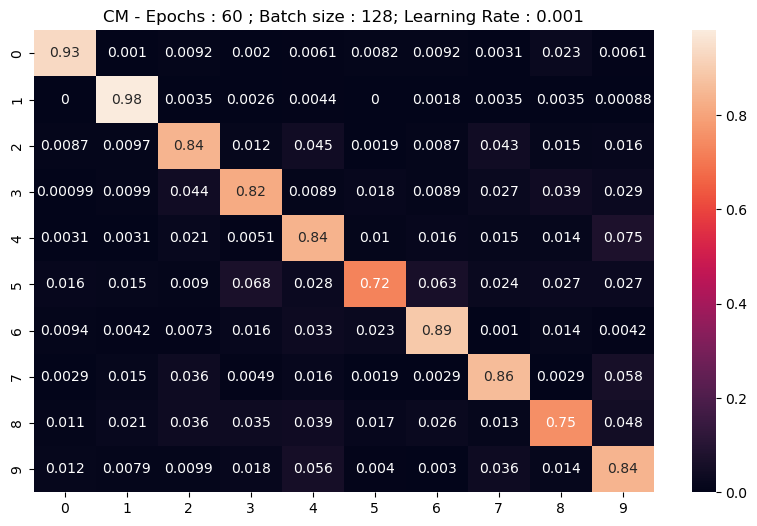

In [20]:
overall_conf_matrix = confusion_matrix(true, preds, normalize='true')

plt.figure(figsize = (10, 6))
sns.heatmap(overall_conf_matrix, annot = True)  
plt.title(f'CM - Epochs : {EPOCHS} ; Batch size : {BATCH_SIZE}; Learning Rate : {LR}')
plt.show()

We can also plot a ROC Curve for each class to check specificity and sensitivity

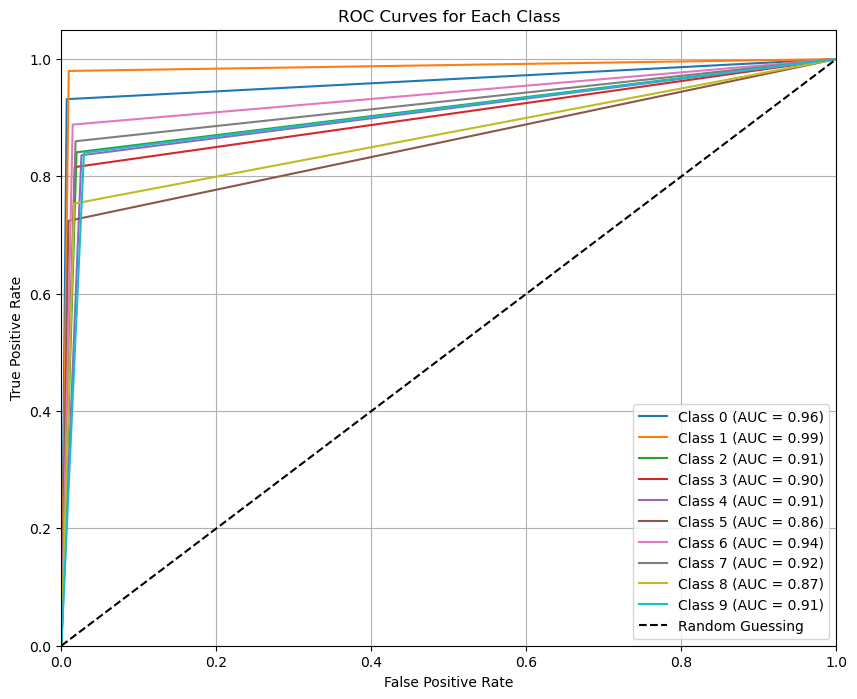

In [21]:
def plot_multiclass_roc(y_true, y_pred, n_classes=10):
    """
    Plots the ROC curve for a multi-class classification problem.

    Args:
    ----
    y_true: array-like
        True class labels (integers from 0 to n_classes-1).

    y_pred_probs: array-like
        Predicted probabilities for each class.

    n_classes: int
        Number of unique classes (default is 10).
    """

    # Binarize the true labels for one-vs-rest comparison
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    y_pred_bin = label_binarize(y_pred, classes=np.arange(n_classes))

    # Initialize the figure
    plt.figure(figsize=(10, 8))

    # Loop over each class and compute ROC curve and AUC
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve for class i
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    # Plot diagonal line (random guessing)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

    # Add labels and title
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(loc="lower right")
    plt.grid(True)

    # Show the plot
    plt.show()


plot_multiclass_roc(true, preds)

To validate the performance of this model, a 6-fold cross-validation process was performed. For this particular cross-validation, the test set was kept constant and only the training set was divided according to k-fold.

In [22]:
def cross_val_data(X_train, y_train, cross_val_nb):
    '''Function that generates the train, validation and test data for
    the number of folds specified.

    Args
    ---
    X_train : array
        Training image data.
    y_train : array
        Training labels.
    X_test : array
        Test image data.
    y_test : array
        Test labels.
    cross_val_nb : int
        Number of cross-validation folds.

    Returns
    ---
    folds : list of tuples
        Each tuple contains (X_train_fold, y_train_fold, X_val_fold, y_val_fold)
        for each cross-validation fold.
    '''
    # Shuffle the entire dataset
    ns = X_train.shape[0]
    shuffle_index = np.random.permutation(ns)
    images, labels = X_train[shuffle_index], y_train[shuffle_index]

    # Determine the number of samples in each fold
    fold_size = ns // cross_val_nb
    
    # Cross-validation data
    folds = []

    for i in range(cross_val_nb):
        # Define validation set for the current fold
        start_val = i * fold_size
        end_val = (i + 1) * fold_size if i != cross_val_nb - 1 else ns
        
        X_val_fold = images[start_val:end_val]
        y_val_fold = labels[start_val:end_val]
        
        # Define training set for the current fold (exclude the validation fold)
        X_train_fold = np.concatenate((images[:start_val], images[end_val:]), axis=0)
        y_train_fold = np.concatenate((labels[:start_val], labels[end_val:]), axis=0)
        
        # Append the fold to the list as a tuple (X_train_fold, y_train_fold, X_val_fold, y_val_fold)
        folds.append((X_train_fold, y_train_fold, X_val_fold, y_val_fold))
    
    return folds

The code below runs the cross-validation - it does take significant running time (approx 15min).

In [4]:
folds = cross_val_data(X_train, y_train, 6)

# Computation device
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {device}\n")

# Set hyperparameters
PATIENCE = 5
BATCH_SIZE = 128
NUM_WORKERS = 0
EPOCHS = 60
LR = 0.001
LOSS_FN = nn.CrossEntropyLoss(reduction = 'none')

# Fit model - note tex and tey are the same test sets as used previously
losses = []
val_losses = []
for k in folds:
    tx, ty, vx, vy = k
    loss_vector, val_loss_vector = fit(EPOCHS, tx, ty, vx, vy, tex, tey, LOSS_FN, None, early_stopping = True)
    losses.append(loss_vector)
    val_losses.append(val_loss_vector)

NameError: name 'cross_val_data' is not defined

Results of the cross-validation are summarised in this graph: 

![Cross Validation Base](cvbase.png)

We can equally plot the loss functions generated by this cross val to check the training

In [78]:
plt.figure(figsize = (10, 6))
for i, (l, val) in enumerate(zip(losses, val_losses)):
    colour = np.random.rand(3,)
    plt.plot(list(range(len(l))), l, color = colour, label = f'CV{i+1} training loss')
    plt.plot(list(range(len(val))), val, color = colour, label = f'CV{i+1} validation loss',
            linestyle = 'dashed')
plt.xlabel("Number of epochs")
plt.ylabel("Loss value")
plt.title(f'Loss function - Epochs : {EPOCHS} ; Batch size : {BATCH_SIZE}; Learning Rate : {LR}')
plt.legend(loc = 'upper right')
plt.show()

NameError: name 'losses' is not defined

<Figure size 1000x600 with 0 Axes>

Next is the convolutional neural network (CNN), which follows a very similar building process

### Model 2 - CNN

All functions are almost the same as the dense, with the notable exception of the image preparation (which conserves their 3D shape instead of flattening them) and the network itself. First prep the data:

In [23]:
def prep_2d_image(X, y):
    '''Function to prepare image dataset

    Args
    ---
    X : array
        Single 2D image 
    y : array
        Associated label
    '''
    # No transformation of the image
    tensor_X = torch.from_numpy(X.astype(np.float32))

    # Turn labels into class vectors
    tensor_y = torch.as_tensor(y, dtype = torch.long)
    oh_y = nn.functional.one_hot(tensor_y, num_classes = 10)
    oh_y = oh_y.to(torch.float32)
    
    # Yield images
    return tensor_X, oh_y

In [24]:
class MNISTCustomCONV(Dataset):
    '''Custom dataset for processing the MNIST images'''
    def __init__(self, X_path, y_path):
        self.X_path = X_path  # X
        self.y_path = y_path  # Y
    
    def __len__(self):
        return len(self.y_path)
    
    def __getitem__(self, idx):
        image = self.X_path[idx, :, :, :]
        label = self.y_path[idx]
        return prep_2d_image(image, label)

Train, validation and test functions require no change, so the same functions from the previous model can be used. The model however is markedly different.

In [25]:
class CONV(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.lin1 = nn.Linear(1600, 10)
        
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.flatten = nn.Flatten()
        
        self.dropout1 = nn.Dropout(0.3)

        self.relu = nn.ReLU()
        self.softmax = torch.nn.Softmax(dim = 1)

    def forward(self, x):

        out = x.permute(0, 3, 1, 2)  # [batch, width, height, channels] --> [batch, channels, width, height]
        
        out = self.conv1(out)
        out = self.relu(out)
        out = self.batchnorm1(out)
        out = self.pool1(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.batchnorm2(out)
        out = self.pool1(out)
        out = self.flatten(out)
        out = self.lin1(out)
        out = self.softmax(out)

        return out

In [26]:
# Print trainable parameters

model = CONV()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

35018

Now redefine the fit function (it is almost identical as the previous, with only the optimizer and model changing)

In [27]:
def fit_conv(epochs, X_train, y_train, X_val, y_val, X_test, y_test, loss_fn, save_loc, early_stopping = True):
    '''Function to load data and fit model for a set number of epochs and
    a set number of protein embeddings (hence the double for loop).

    Arguments
    ---
    epochs : int
        Number of passes through network
    X_train : array
    y_train : array
    X_val : array
    y_val : array
    X_test : array
    y_test : array
    loss_fn : function
        Loss function to be computed
    save_loc : str
        Where should the results be saved ?
    early_stopping : boolean
        Using early stopping ?

    Returns
    ---
    loss_vectors : list of lists
        Lists of loss values for each epoch
    y_preds : list of lists
        TBC
    '''
    start = time.time()

    # Initialise patience
    if early_stopping:
        print("[INFO]: Initializing early stopping")
        early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0)


    # Create test set.
    loss_vector = []
    val_loss_vector = []
    

    test_dataset = MNISTCustomCONV(X_test, y_test)
    t_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    
    model = CONV().to(device)

    # Set optimizer based on model parameters
    lr = LR
    optimizer = optim.Adam(model.parameters(), 
                        lr=lr ,amsgrad = False) 

    # Train model for set number of epochs
    for epoch in range(epochs):
        #Create the datasets and dataloaders for training with shuffle each step
        train_data = MNISTCustomCONV(X_train, y_train)
        val_data = MNISTCustomCONV(X_val, y_val)
        train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
        val_loss = validate(model, val_loader, loss_fn, epoch)
        loss_vector.append(train_loss)
        val_loss_vector.append(val_loss)

        if early_stopping:
            early_stopping(val_loss)
            if early_stopping.early_stop:
                break

    test_loss, predictions, real_vals = test(model, t_loader, loss_fn, epochs, '../results')

    # Save weights of each model
    # model_name = f'{path[29:]}_{CURRENT_CV}'
    # save_model(epochs, model, optimizer, loss_fn, save_loc, model_name)
    
    end = time.time()
    
    print(f"Training time: {(end-start)/60:.3f} minutes\n")
    # print(len(predictions_across_embds))
    print("Model complete")
    return loss_vector, val_loss_vector, predictions, real_vals

This model took much longer to train, so parameters could only be optimised manually - results from the previous grid search were used to settle on the hyperparameters of the model. Below is the code to train the model - this may take between 10 and 18 minutes.

In [28]:
# Computation device
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {device}\n")

# Set hyperparameters
PATIENCE = 5
BATCH_SIZE = 128
NUM_WORKERS = 0
EPOCHS = 60
LR = 0.001
LOSS_FN = nn.CrossEntropyLoss(reduction = 'none')

loss_vector, val_loss_vector, preds, true = fit_conv(EPOCHS, tx, ty, vx, vy, tex, tey, 
                                                LOSS_FN, None, early_stopping = True)

Computation device: cpu

[INFO]: Initializing early stopping


Epoch 0: 100%|██████████████████████████████████████████████| 459/459 [00:31<00:00, 14.53batch/s, Train: loss=243.69471]



 Training performance across images : 

Balanced Accuracy Score : 0.5641420336568321
Matthews CC : 0.5242610363739193

 Validation performance across images : 

Balanced Accuracy Score : 0.7992221837260767
Matthews CC : 0.7830396454087347


Epoch 1: 100%|██████████████████████████████████████████████| 459/459 [00:30<00:00, 15.26batch/s, Train: loss=211.59390]



 Training performance across images : 

Balanced Accuracy Score : 0.8202795034299439
Matthews CC : 0.802971550945906

 Validation performance across images : 

Balanced Accuracy Score : 0.8618646564719958
Matthews CC : 0.8500370130953557


Epoch 2: 100%|██████████████████████████████████████████████| 459/459 [00:28<00:00, 16.32batch/s, Train: loss=205.37882]



 Training performance across images : 

Balanced Accuracy Score : 0.8646941628540021
Matthews CC : 0.8513574542072756

 Validation performance across images : 

Balanced Accuracy Score : 0.8864145140702403
Matthews CC : 0.8767227008120375


Epoch 3: 100%|██████████████████████████████████████████████| 459/459 [00:28<00:00, 16.15batch/s, Train: loss=202.90645]



 Training performance across images : 

Balanced Accuracy Score : 0.8815464072956315
Matthews CC : 0.869719930051011

 Validation performance across images : 

Balanced Accuracy Score : 0.8916494146627076
Matthews CC : 0.8819118247450568


Epoch 4: 100%|██████████████████████████████████████████████| 459/459 [00:28<00:00, 16.18batch/s, Train: loss=201.40144]



 Training performance across images : 

Balanced Accuracy Score : 0.8919209601536734
Matthews CC : 0.8810441143471042

 Validation performance across images : 

Balanced Accuracy Score : 0.8995554012303124
Matthews CC : 0.8910383702305409


Epoch 5: 100%|██████████████████████████████████████████████| 459/459 [00:28<00:00, 16.34batch/s, Train: loss=200.42684]



 Training performance across images : 

Balanced Accuracy Score : 0.8989879282559707
Matthews CC : 0.8888529745135216

 Validation performance across images : 

Balanced Accuracy Score : 0.9164363804256253
Matthews CC : 0.9085494208982524


Epoch 6: 100%|██████████████████████████████████████████████| 459/459 [00:27<00:00, 16.63batch/s, Train: loss=199.62111]



 Training performance across images : 

Balanced Accuracy Score : 0.903640190209422
Matthews CC : 0.8939033051879861

 Validation performance across images : 

Balanced Accuracy Score : 0.9039106816644807
Matthews CC : 0.8944293637003514
[INFO]: Early stopping counter - 1 of 5


Epoch 7: 100%|██████████████████████████████████████████████| 459/459 [00:27<00:00, 16.55batch/s, Train: loss=199.19257]



 Training performance across images : 

Balanced Accuracy Score : 0.9070911207591491
Matthews CC : 0.897720252447843

 Validation performance across images : 

Balanced Accuracy Score : 0.9148887512399965
Matthews CC : 0.9058837827467946


Epoch 8: 100%|██████████████████████████████████████████████| 459/459 [00:27<00:00, 16.84batch/s, Train: loss=198.60986]



 Training performance across images : 

Balanced Accuracy Score : 0.9112014296626659
Matthews CC : 0.9022282012909424

 Validation performance across images : 

Balanced Accuracy Score : 0.9151580275776855
Matthews CC : 0.9069040830891305
[INFO]: Early stopping counter - 1 of 5


Epoch 9: 100%|██████████████████████████████████████████████| 459/459 [00:28<00:00, 16.20batch/s, Train: loss=198.20492]



 Training performance across images : 

Balanced Accuracy Score : 0.9146513954752591
Matthews CC : 0.9060464531452748

 Validation performance across images : 

Balanced Accuracy Score : 0.9139055684777848
Matthews CC : 0.905050559893181
[INFO]: Early stopping counter - 2 of 5


Epoch 10: 100%|█████████████████████████████████████████████| 459/459 [00:29<00:00, 15.52batch/s, Train: loss=198.03881]



 Training performance across images : 

Balanced Accuracy Score : 0.9152117069278211
Matthews CC : 0.9065920041668186

 Validation performance across images : 

Balanced Accuracy Score : 0.915056880056144
Matthews CC : 0.906671609901914


Epoch 11: 100%|█████████████████████████████████████████████| 459/459 [00:29<00:00, 15.57batch/s, Train: loss=197.79327]



 Training performance across images : 

Balanced Accuracy Score : 0.9166263751165671
Matthews CC : 0.908188683436803

 Validation performance across images : 

Balanced Accuracy Score : 0.9224201347409418
Matthews CC : 0.915662152769511


Epoch 12: 100%|█████████████████████████████████████████████| 459/459 [00:29<00:00, 15.77batch/s, Train: loss=197.27538]



 Training performance across images : 

Balanced Accuracy Score : 0.9217137560164652
Matthews CC : 0.9137232944489427

 Validation performance across images : 

Balanced Accuracy Score : 0.9143495038340627
Matthews CC : 0.9050402071203806
[INFO]: Early stopping counter - 1 of 5


Epoch 13: 100%|█████████████████████████████████████████████| 459/459 [00:30<00:00, 15.24batch/s, Train: loss=197.24381]



 Training performance across images : 

Balanced Accuracy Score : 0.9210336006594234
Matthews CC : 0.9129529694254144

 Validation performance across images : 

Balanced Accuracy Score : 0.9139946155324814
Matthews CC : 0.9049655884614104
[INFO]: Early stopping counter - 2 of 5


Epoch 14: 100%|█████████████████████████████████████████████| 459/459 [00:28<00:00, 16.03batch/s, Train: loss=196.97491]



 Training performance across images : 

Balanced Accuracy Score : 0.9234886586701061
Matthews CC : 0.9156171547823665

 Validation performance across images : 

Balanced Accuracy Score : 0.9229684346753707
Matthews CC : 0.9147672093115328
[INFO]: Early stopping counter - 3 of 5


Epoch 15: 100%|█████████████████████████████████████████████| 459/459 [00:28<00:00, 15.94batch/s, Train: loss=196.89295]



 Training performance across images : 

Balanced Accuracy Score : 0.9233508840605115
Matthews CC : 0.9154296522372736

 Validation performance across images : 

Balanced Accuracy Score : 0.9099103787462386
Matthews CC : 0.9014838700646123
[INFO]: Early stopping counter - 4 of 5


Epoch 16: 100%|█████████████████████████████████████████████| 459/459 [00:29<00:00, 15.58batch/s, Train: loss=196.56142]



 Training performance across images : 

Balanced Accuracy Score : 0.9261069198190246
Matthews CC : 0.9186237055898854

 Validation performance across images : 

Balanced Accuracy Score : 0.9270409933407114
Matthews CC : 0.918214226216268


Epoch 17: 100%|█████████████████████████████████████████████| 459/459 [00:29<00:00, 15.38batch/s, Train: loss=196.41383]



 Training performance across images : 

Balanced Accuracy Score : 0.9268541973014983
Matthews CC : 0.9194557683793685

 Validation performance across images : 

Balanced Accuracy Score : 0.921762043458511
Matthews CC : 0.9138085032904799
[INFO]: Early stopping counter - 1 of 5


Epoch 18: 100%|█████████████████████████████████████████████| 459/459 [00:29<00:00, 15.46batch/s, Train: loss=196.33079]



 Training performance across images : 

Balanced Accuracy Score : 0.927905487222078
Matthews CC : 0.9205735880418924

 Validation performance across images : 

Balanced Accuracy Score : 0.9265039121509027
Matthews CC : 0.9182710152980249
[INFO]: Early stopping counter - 2 of 5


Epoch 19: 100%|█████████████████████████████████████████████| 459/459 [00:30<00:00, 15.27batch/s, Train: loss=196.11933]



 Training performance across images : 

Balanced Accuracy Score : 0.9296678527650772
Matthews CC : 0.9225216606397217

 Validation performance across images : 

Balanced Accuracy Score : 0.9233415816223889
Matthews CC : 0.9155882797107828
[INFO]: Early stopping counter - 3 of 5


Epoch 20: 100%|█████████████████████████████████████████████| 459/459 [00:28<00:00, 15.89batch/s, Train: loss=196.13223]



 Training performance across images : 

Balanced Accuracy Score : 0.9290777645503031
Matthews CC : 0.9218791407195788

 Validation performance across images : 

Balanced Accuracy Score : 0.915897787587974
Matthews CC : 0.9067612738660303
[INFO]: Early stopping counter - 4 of 5


Epoch 21: 100%|█████████████████████████████████████████████| 459/459 [00:28<00:00, 15.83batch/s, Train: loss=196.08923]



 Training performance across images : 

Balanced Accuracy Score : 0.9293589653633779
Matthews CC : 0.9221765778877854

 Validation performance across images : 

Balanced Accuracy Score : 0.9275374485719837
Matthews CC : 0.920035593463525


Epoch 22: 100%|█████████████████████████████████████████████| 459/459 [00:29<00:00, 15.50batch/s, Train: loss=195.84996]



 Training performance across images : 

Balanced Accuracy Score : 0.9312163468135954
Matthews CC : 0.9242072717910216

 Validation performance across images : 

Balanced Accuracy Score : 0.9283310123258494
Matthews CC : 0.9200576297471801
[INFO]: Early stopping counter - 1 of 5


Epoch 23: 100%|█████████████████████████████████████████████| 459/459 [00:33<00:00, 13.52batch/s, Train: loss=195.64461]



 Training performance across images : 

Balanced Accuracy Score : 0.9327321799749001
Matthews CC : 0.9258921480071463

 Validation performance across images : 

Balanced Accuracy Score : 0.9277690285336394
Matthews CC : 0.9200025910548806
[INFO]: Early stopping counter - 2 of 5


Epoch 24: 100%|█████████████████████████████████████████████| 459/459 [00:30<00:00, 15.30batch/s, Train: loss=195.64840]



 Training performance across images : 

Balanced Accuracy Score : 0.9323219974861658
Matthews CC : 0.9253979364156015

 Validation performance across images : 

Balanced Accuracy Score : 0.9260621449146249
Matthews CC : 0.9173174415291927
[INFO]: Early stopping counter - 3 of 5


Epoch 25: 100%|█████████████████████████████████████████████| 459/459 [00:29<00:00, 15.39batch/s, Train: loss=195.80803]



 Training performance across images : 

Balanced Accuracy Score : 0.9314020003310081
Matthews CC : 0.9244495653004439

 Validation performance across images : 

Balanced Accuracy Score : 0.9295057215759
Matthews CC : 0.9218539053228864
[INFO]: Early stopping counter - 4 of 5


Epoch 26: 100%|█████████████████████████████████████████████| 459/459 [00:29<00:00, 15.72batch/s, Train: loss=195.49152]



 Training performance across images : 

Balanced Accuracy Score : 0.9338489924679548
Matthews CC : 0.9270588092821554

 Validation performance across images : 

Balanced Accuracy Score : 0.9167831900354676
Matthews CC : 0.9077012354484688
[INFO]: Early stopping counter - 5 of 5
[INFO]: Early stopping

 Test performance across images : 

Balanced Accuracy Score : 0.9240745313172866
Matthews CC : 0.9165817749365355
Training time: 13.273 minutes

Model complete


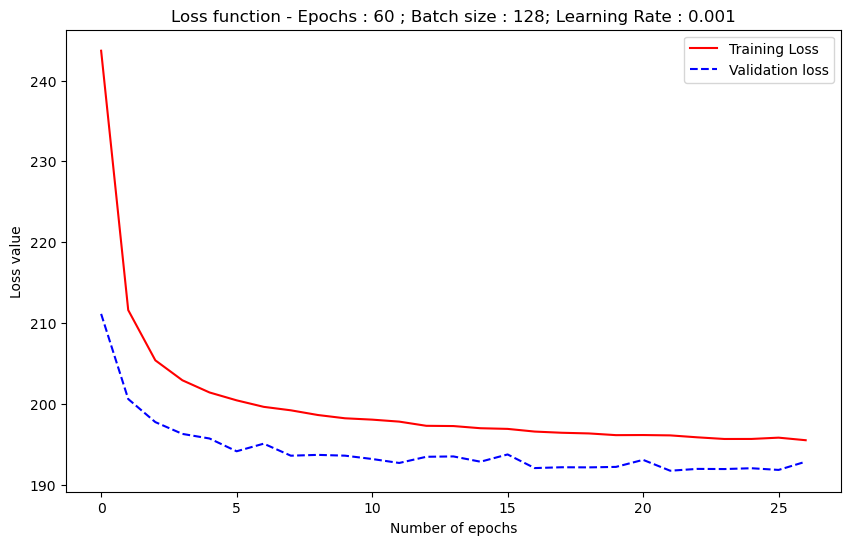

In [29]:
# Plot loss function

plot_loss_function(loss_vector, val_loss_vector)

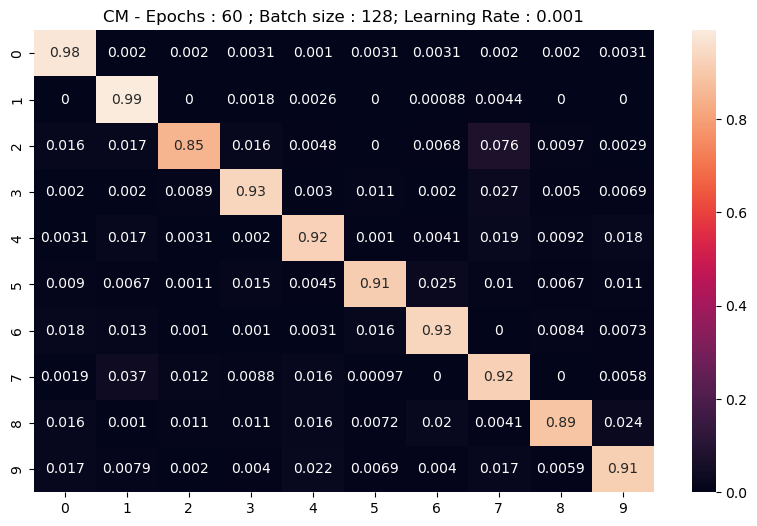

In [30]:
# Plot confidence matrix

overall_conf_matrix = confusion_matrix(true, preds, normalize='true')

plt.figure(figsize = (10, 6))
sns.heatmap(overall_conf_matrix, annot = True)  
plt.title(f'CM - Epochs : {EPOCHS} ; Batch size : {BATCH_SIZE}; Learning Rate : {LR}')
plt.show()

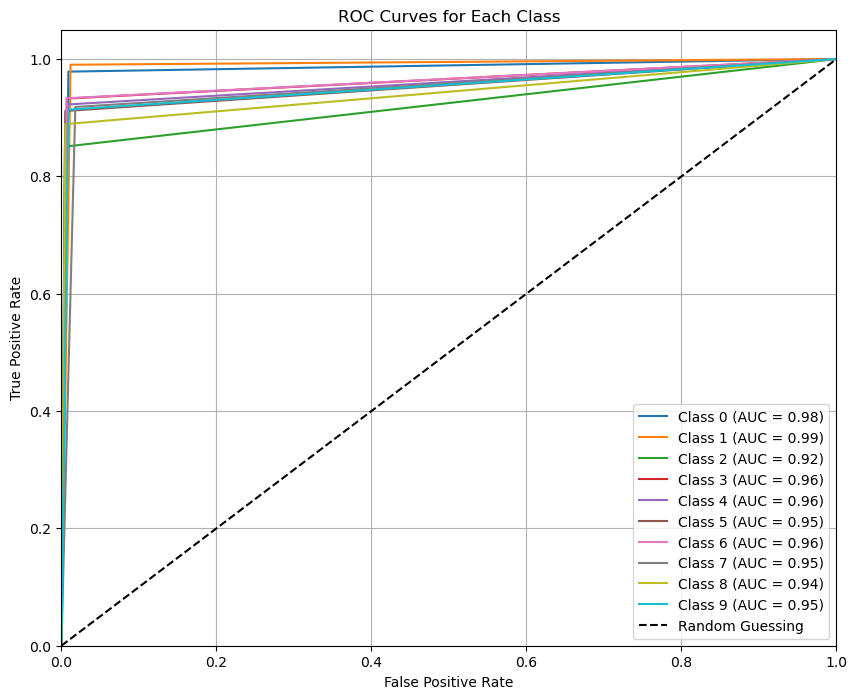

In [31]:
# Plot ROC curve

plot_multiclass_roc(true, preds)

Just as the previous model, a 6-fold cross validation was performed. The code to perform this was exactly as above, the only difference being the fit function. The results are summarised below : 

![Cross Validation Conv](cvconv.png)

We can verify that the CNN performs better than the FC Model using a simple Wilcoxon statistic, which does not assume any distribution

In [32]:
# Balanced accuracies for each model across CVs
fc_ba = [0.82, 0.76, 0.87, 0.83, 0.76, 0.76]
conv_ba = [0.92, 0.935, 0.94, 0.93, 0.92, 0.94]

# Perform Wilcoxon test

def wilcoxon_test(vec1, vec2):
    '''Function to compare differences in correlation between two different
    embedding combinations.

    Args
    ---
    matrix_1 : list of lists
    matrix_2 : list of lists (same size)

    Returns
    ---
    c_pval : list
        Corrected p-values for each protein
    '''
    errors = np.array(vec2) - np.array(vec1)
    res = wilcoxon(errors, alternative='less')
    uncorrected_pvals = res.pvalue

    print(f'Wilcoxon p-value : {uncorrected_pvals}')


wilcoxon_test(conv_ba, fc_ba)


Wilcoxon p-value : 0.015625


## Dataset 2 : Localization

This dataset is composed of protein PSSM and different classes of cellular localization. We can download the data from a github repo.

In [33]:
import os
import re
import time
import argparse
import random
import datetime as dt
import requests
import zipfile
from pandas import read_csv

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import IterableDataset, DataLoader, Dataset

from tqdm.autonotebook import tqdm

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import roc_curve, RocCurveDisplay, PrecisionRecallDisplay, matthews_corrcoef

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
def download_data():
    url="https://github.com/JJAlmagro/subcellular_localization/raw/refs/heads/master/notebook%20tutorial/data/reduced_train.npz"
    datasetFolderPath = "data/localization/"
    file = "reduced_train.npz"
    FilePath = os.path.join(datasetFolderPath, file)

    if not os.path.exists(datasetFolderPath):
        os.makedirs(datasetFolderPath)

    def download_file(url, filename):
        response = requests.get(url, stream=True)
        with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=filename) as fout:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)

    # Download the zip file if it does not exist
    if not os.path.exists(FilePath):
        download_file(url, FilePath)

In [5]:
download_data()

data/localization/reduced_train.npz:  11%|████▍                                     | 928k/8.52M [00:27<03:53, 34.1kB/s]


KeyboardInterrupt: 

Alternatively to downloading, you can use a pre-existing path to the data

In [34]:
data_path = 'mnist_cnns/data/localization/reduced_train.npz'

dataset = np.load(data_path)
X_train = dataset["X_train"]
y = dataset["y_train"]
mask_train = dataset["mask_train"]

We can analyse some of of this data

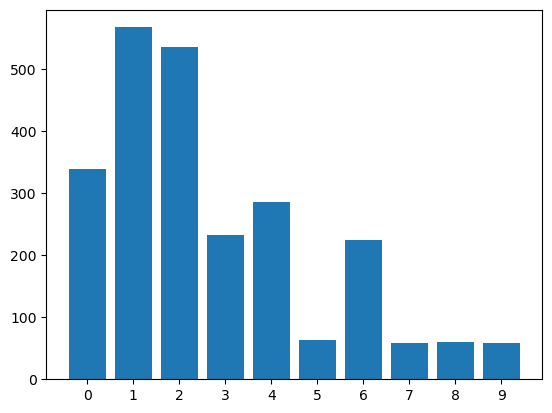

In [35]:
# Looking at counts of each class

unique, counts = np.unique(y, return_counts=True)
plt.bar(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], counts)
plt.show()

We seem to have quite an imbalanced dataset - we can resolve this using class weights, that will be used during the training.

In [36]:
# Compute class weights

class_labels = np.unique(y)
class_weights = compute_class_weight('balanced', classes = class_labels, y = y)
class_weights = torch.tensor(class_weights)

We can now create the train, validation and test set.

In [37]:
def train_validation_test(X_train, y_train, mask_train, val_proportion = 0.1, test_proportion = 0.2):
    '''Simple function to create our train, validation and test sets
    Based on previously handed out format of data.
    
    Args
    ---
    X_train : array
    y_train : array
    mask_train : array
    val_proportion : float
    test_proportion : float


    Returns
    ---
    X_tr : array
    y_tr : array
    X_val : array
    y_val : array
    X_test : array
    y_test : array
    '''
    # Shuffle data set
    ns =  X_train.shape[0]
    shuffle_index = np.random.permutation(ns)
    train_images, train_labels, masks = X_train[shuffle_index,:,:], y_train[shuffle_index], mask_train[shuffle_index]


    # Set test and validation index
    val_size = int(ns * val_proportion)
    test_size = int(ns * test_proportion)

    val_index = val_size + test_size

    # Create train, test and validation
    X_tr = train_images[:-val_index,:,:]
    y_tr = train_labels[:-val_index]
    masks_tr = masks[:-val_index]
    X_val = train_images[-val_index:-test_size,:,:]
    y_val = train_labels[-val_index:-test_size]
    masks_val = masks[-val_index:-test_size]
    X_te = train_images[-test_size:,:,:]
    y_te = train_labels[-test_size:]
    masks_te = masks[-test_size:]
    
    return X_tr, y_tr, masks_tr, X_val, y_val, masks_val, X_te, y_te, masks_te


tx, ty, tm, vx, vy, vm, tex, tey, tem = train_validation_test(X_train, y, mask_train)

We can now build our models. This time, we will be testing two different architectures: a basic CNN model and a ResNet model.

### Model 1 : CNN

In [38]:
def prep_data(X, y, mask):
    '''Function to prepare localization dataset

    Args
    ---
    X : array
        Features 
    y : array
        Associated label
    mask : array
        Provided vector for masking parts of the image
    '''
    # Masking of the image
    masked_image = np.transpose(X) * mask
    masked_image = np.transpose(masked_image)
    tensor_X = torch.from_numpy(X.astype(np.float32))

    # Turn labels into class vectors
    tensor_y = torch.as_tensor(y, dtype = torch.long)
    oh_y = nn.functional.one_hot(tensor_y, num_classes = 10)
    oh_y = oh_y.to(torch.float32)
    
    # Yield images
    return tensor_X, oh_y

In [39]:
class LocalizationCustom(Dataset):
    '''Custom dataset for processing the Localization data'''
    def __init__(self, X_path, y_path, mask):
        self.X_path = X_path  # X
        self.y_path = y_path  # Y
        self.mask = mask      # Masking vector
    
    def __len__(self):
        return len(self.y_path)
    
    def __getitem__(self, idx):
        image = self.X_path[idx, :, :]
        label = self.y_path[idx]
        mask = self.mask[idx]
        return prep_data(image, label, mask)

With these functions created, we can now define the architecture of our first model

In [40]:
class CONVLoc(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(20, 64, kernel_size=3, padding='same')
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv1d(64, 32, kernel_size=3, padding='same')
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.batchnorm2 = nn.BatchNorm1d(32)

        self.conv3 = nn.Conv1d(32, 16, kernel_size=1, padding='same')
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.batchnorm3 = nn.BatchNorm1d(16)
        
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(800, 10)
        self.softmax = torch.nn.Softmax(dim = 1)

        self.relu = nn.ReLU()

    def forward(self, x):

        out = x.permute(0, 2, 1)  # [batch, length, features] --> [batch, features, length]
        
        out = self.conv1(out)
        out = self.pool1(out)
        out = self.batchnorm1(out)
        out = self.dropout1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.pool2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.pool3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)

        out = self.flatten(out)
        out = self.lin1(out)
        out = self.softmax(out)

        return out

In [41]:
# Print number of trainable parameters

model = CONVLoc()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

18842

Once again, the previously defined train, validation and test functions can be reused for this model (make sure they have been loaded, as well as the Early Stopping function) - only the fitting function needs to change.

In [42]:
def fit_conv_loc(epochs, X_train, y_train, mask_train, X_val, y_val, mask_val, X_test, y_test, mask_test, 
        loss_fn, save_loc, early_stopping = True):
    '''Function to load data and fit model for a set number of epochs and
    a set number of protein embeddings (hence the double for loop).

    Arguments
    ---
    epochs : int
        Number of passes through network
    X_train : array
    y_train : array
    X_val : array
    y_val : array
    X_test : array
    y_test : array
    loss_fn : function
        Loss function to be computed
    save_loc : str
        Where should the results be saved ?
    early_stopping : boolean
        Using early stopping ?

    Returns
    ---
    loss_vectors : list of lists
        Lists of loss values for each epoch
    y_preds : list of lists
        TBC
    '''
    start = time.time()

    # Initialise patience
    if early_stopping:
        print("[INFO]: Initializing early stopping")
        early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0)


    # Create test set.
    loss_vector = []
    val_loss_vector = []
    

    test_dataset = LocalizationCustom(X_test, y_test, mask_test)
    t_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    
    model = CONVLoc().to(device)

    # Set optimizer based on model parameters
    lr = LR
    optimizer = optim.Adam(model.parameters(), 
                        lr=lr ,amsgrad = False) 

    # Train model for set number of epochs
    for epoch in range(epochs):
        #Create the datasets and dataloaders for training with shuffle each step
        train_data = LocalizationCustom(X_train, y_train, mask_train)
        val_data = LocalizationCustom(X_val, y_val, mask_val)
        train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
        val_loss = validate(model, val_loader, loss_fn, epoch)
        loss_vector.append(train_loss)
        val_loss_vector.append(val_loss)

        if early_stopping:
            early_stopping(val_loss)
            if early_stopping.early_stop:
                break

    test_loss, predictions, real_vals = test(model, t_loader, loss_fn, epochs, '../results')

    # Save weights of each model
    # model_name = f'{path[29:]}_{CURRENT_CV}'
    # save_model(epochs, model, optimizer, loss_fn, save_loc, model_name)
    
    end = time.time()
    
    print(f"Training time: {(end-start)/60:.3f} minutes\n")
    # print(len(predictions_across_embds))
    print("Model complete")
    return loss_vector, val_loss_vector, predictions, real_vals


In [45]:
# Computation device
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {device}\n")

# Set hyperparameters
PATIENCE = 5
BATCH_SIZE = 64
NUM_WORKERS = 0
EPOCHS = 60
LR = 0.001
LOSS_FN = nn.CrossEntropyLoss(reduction = 'none', weight = class_weights) # Include class weights

loss_vector, val_loss_vector, preds, true = fit_conv_loc(EPOCHS, tx, ty, tm, vx, vy, vm, tex, tey, tem, 
                                   LOSS_FN, None, early_stopping = True)

Computation device: cpu

[INFO]: Initializing early stopping


Epoch 0: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 11.99batch/s, Train: loss=143.85383]



 Training performance across images : 

Balanced Accuracy Score : 0.1729192394018467
Matthews CC : 0.08247904685037269

 Validation performance across images : 

Balanced Accuracy Score : 0.1
Matthews CC : 0.0


Epoch 1: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 11.29batch/s, Train: loss=136.11047]



 Training performance across images : 

Balanced Accuracy Score : 0.36293458174900534
Matthews CC : 0.23219597223771518

 Validation performance across images : 

Balanced Accuracy Score : 0.3214277238892538
Matthews CC : 0.31031893535476496


Epoch 2: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.74batch/s, Train: loss=128.95467]



 Training performance across images : 

Balanced Accuracy Score : 0.48171725939588955
Matthews CC : 0.35962620143982443

 Validation performance across images : 

Balanced Accuracy Score : 0.5120673771292638
Matthews CC : 0.4530533263186916


Epoch 3: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 11.68batch/s, Train: loss=122.00490]



 Training performance across images : 

Balanced Accuracy Score : 0.5949380146801654
Matthews CC : 0.5100457332102586

 Validation performance across images : 

Balanced Accuracy Score : 0.5907238838985048
Matthews CC : 0.5717710167719917


Epoch 4: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 13.49batch/s, Train: loss=115.85603]



 Training performance across images : 

Balanced Accuracy Score : 0.7073473769767705
Matthews CC : 0.6337332835677243

 Validation performance across images : 

Balanced Accuracy Score : 0.6357537113826142
Matthews CC : 0.6252401486365533


Epoch 5: 100%|████████████████████████████████████████████████| 27/27 [00:01<00:00, 13.86batch/s, Train: loss=111.18369]



 Training performance across images : 

Balanced Accuracy Score : 0.7714236770991235
Matthews CC : 0.7112047163121776

 Validation performance across images : 

Balanced Accuracy Score : 0.6790953154289462
Matthews CC : 0.6759901778987099


Epoch 6: 100%|████████████████████████████████████████████████| 27/27 [00:01<00:00, 13.80batch/s, Train: loss=108.08111]



 Training performance across images : 

Balanced Accuracy Score : 0.8124838876436374
Matthews CC : 0.7482099071897417

 Validation performance across images : 

Balanced Accuracy Score : 0.6955148083158788
Matthews CC : 0.7088520282234826


Epoch 7: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.65batch/s, Train: loss=105.83685]



 Training performance across images : 

Balanced Accuracy Score : 0.8388968470441462
Matthews CC : 0.7750409693019128

 Validation performance across images : 

Balanced Accuracy Score : 0.6978470831213918
Matthews CC : 0.6948093193659012


Epoch 8: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 13.39batch/s, Train: loss=103.94638]



 Training performance across images : 

Balanced Accuracy Score : 0.8565337578433743
Matthews CC : 0.8011844461274737

 Validation performance across images : 

Balanced Accuracy Score : 0.7155542092501281
Matthews CC : 0.7317694342969436


Epoch 9: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 13.42batch/s, Train: loss=102.33131]



 Training performance across images : 

Balanced Accuracy Score : 0.890005719971637
Matthews CC : 0.8321051907327512

 Validation performance across images : 

Balanced Accuracy Score : 0.7147046276690567
Matthews CC : 0.7222866722577659


Epoch 10: 100%|███████████████████████████████████████████████| 27/27 [00:01<00:00, 13.92batch/s, Train: loss=101.23964]



 Training performance across images : 

Balanced Accuracy Score : 0.89739409708772
Matthews CC : 0.8449659421023679

 Validation performance across images : 

Balanced Accuracy Score : 0.7327412888842415
Matthews CC : 0.7566109672264503


Epoch 11: 100%|███████████████████████████████████████████████| 27/27 [00:02<00:00, 12.80batch/s, Train: loss=100.10219]



 Training performance across images : 

Balanced Accuracy Score : 0.9127215313807909
Matthews CC : 0.8649980706720475

 Validation performance across images : 

Balanced Accuracy Score : 0.7151442772874531
Matthews CC : 0.7542867810210409


Epoch 12: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 13.03batch/s, Train: loss=99.54585]



 Training performance across images : 

Balanced Accuracy Score : 0.919659643047426
Matthews CC : 0.8758624943609293

 Validation performance across images : 

Balanced Accuracy Score : 0.732476458375767
Matthews CC : 0.7627502788637575
[INFO]: Early stopping counter - 1 of 5


Epoch 13: 100%|████████████████████████████████████████████████| 27/27 [00:01<00:00, 13.80batch/s, Train: loss=98.79193]



 Training performance across images : 

Balanced Accuracy Score : 0.9274451418220782
Matthews CC : 0.8908293623472117

 Validation performance across images : 

Balanced Accuracy Score : 0.7325463571103625
Matthews CC : 0.761277458196204


Epoch 14: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 13.42batch/s, Train: loss=98.50251]



 Training performance across images : 

Balanced Accuracy Score : 0.9252712459956886
Matthews CC : 0.8853922714568572

 Validation performance across images : 

Balanced Accuracy Score : 0.6984065319117727
Matthews CC : 0.763301423513064
[INFO]: Early stopping counter - 1 of 5


Epoch 15: 100%|████████████████████████████████████████████████| 27/27 [00:01<00:00, 13.84batch/s, Train: loss=98.34696]



 Training performance across images : 

Balanced Accuracy Score : 0.929596185303519
Matthews CC : 0.8977898382945584

 Validation performance across images : 

Balanced Accuracy Score : 0.7467169058928649
Matthews CC : 0.7850137756241552


Epoch 16: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 11.95batch/s, Train: loss=97.73537]



 Training performance across images : 

Balanced Accuracy Score : 0.9368240994790293
Matthews CC : 0.9054272071893044

 Validation performance across images : 

Balanced Accuracy Score : 0.7451574517018317
Matthews CC : 0.784778530315801
[INFO]: Early stopping counter - 1 of 5


Epoch 17: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 13.22batch/s, Train: loss=97.42478]



 Training performance across images : 

Balanced Accuracy Score : 0.9410001786660931
Matthews CC : 0.9123560768943955

 Validation performance across images : 

Balanced Accuracy Score : 0.732191515203335
Matthews CC : 0.7934741597904029


Epoch 18: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 13.16batch/s, Train: loss=96.93562]



 Training performance across images : 

Balanced Accuracy Score : 0.9471327311303795
Matthews CC : 0.9205966314952977

 Validation performance across images : 

Balanced Accuracy Score : 0.7339459011682472
Matthews CC : 0.7981539372556932
[INFO]: Early stopping counter - 1 of 5


Epoch 19: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.96batch/s, Train: loss=96.88078]



 Training performance across images : 

Balanced Accuracy Score : 0.9478508670659155
Matthews CC : 0.9221086988777004

 Validation performance across images : 

Balanced Accuracy Score : 0.7339459011682472
Matthews CC : 0.7987065281487703


Epoch 20: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.37batch/s, Train: loss=96.67782]



 Training performance across images : 

Balanced Accuracy Score : 0.9497896244593351
Matthews CC : 0.9212396647146808

 Validation performance across images : 

Balanced Accuracy Score : 0.7209397488723983
Matthews CC : 0.7684836894338587


Epoch 21: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.59batch/s, Train: loss=96.45011]



 Training performance across images : 

Balanced Accuracy Score : 0.9510075706580198
Matthews CC : 0.9221138086877599

 Validation performance across images : 

Balanced Accuracy Score : 0.7341243133002723
Matthews CC : 0.789332047925863
[INFO]: Early stopping counter - 1 of 5


Epoch 22: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 13.06batch/s, Train: loss=96.13098]



 Training performance across images : 

Balanced Accuracy Score : 0.957172773072509
Matthews CC : 0.9351449931701166

 Validation performance across images : 

Balanced Accuracy Score : 0.7252929127650358
Matthews CC : 0.7842236357451882
[INFO]: Early stopping counter - 2 of 5


Epoch 23: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 11.65batch/s, Train: loss=95.98194]



 Training performance across images : 

Balanced Accuracy Score : 0.9594697908772046
Matthews CC : 0.9379713311105812

 Validation performance across images : 

Balanced Accuracy Score : 0.7271662401512982
Matthews CC : 0.779391790402428
[INFO]: Early stopping counter - 3 of 5


Epoch 24: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.07batch/s, Train: loss=95.89289]



 Training performance across images : 

Balanced Accuracy Score : 0.9588360099119171
Matthews CC : 0.9385928822585777

 Validation performance across images : 

Balanced Accuracy Score : 0.7410333437624919
Matthews CC : 0.8072635133445368
[INFO]: Early stopping counter - 4 of 5


Epoch 25: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.56batch/s, Train: loss=95.72431]



 Training performance across images : 

Balanced Accuracy Score : 0.9612473541498423
Matthews CC : 0.9408124463708526

 Validation performance across images : 

Balanced Accuracy Score : 0.7303776585277478
Matthews CC : 0.7983468495453776
[INFO]: Early stopping counter - 5 of 5
[INFO]: Early stopping

 Test performance across images : 

Balanced Accuracy Score : 0.7591846103754529
Matthews CC : 0.8017844035817147
Training time: 1.003 minutes

Model complete


After training, we can evaluate the loss and classification of our model

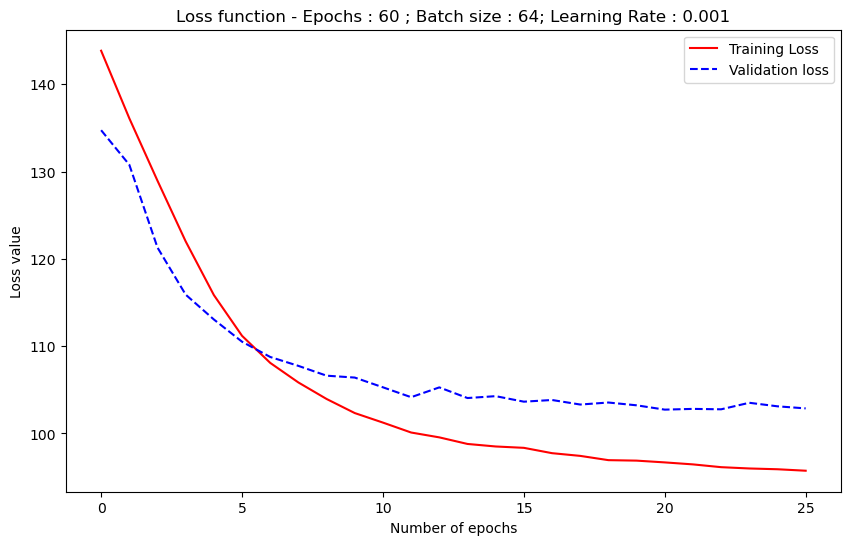

In [46]:
plot_loss_function(loss_vector, val_loss_vector)

Seems to be a bit of overfitting - architecture may need to be finetuned

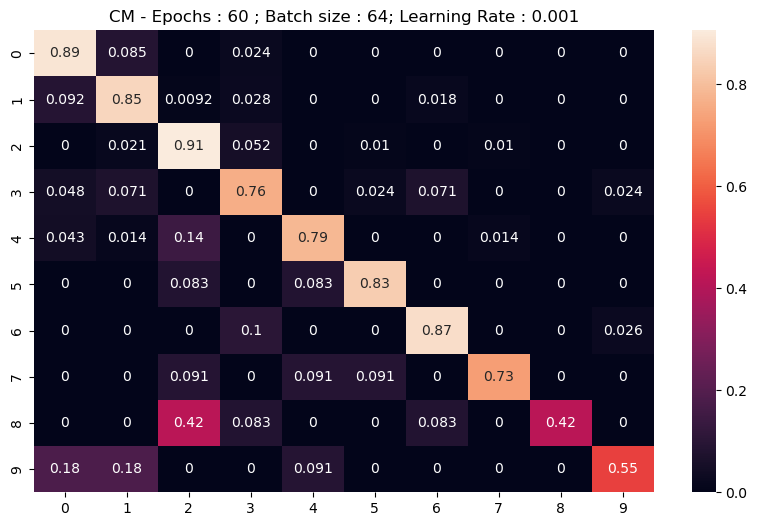

In [47]:
overall_conf_matrix = confusion_matrix(true, preds, normalize='true')

plt.figure(figsize = (10, 6))
sns.heatmap(overall_conf_matrix, annot = True)  
plt.title(f'CM - Epochs : {EPOCHS} ; Batch size : {BATCH_SIZE}; Learning Rate : {LR}')
plt.show()

Big errors on class 8 and 9 notably - we can represent the ROC curves for each class

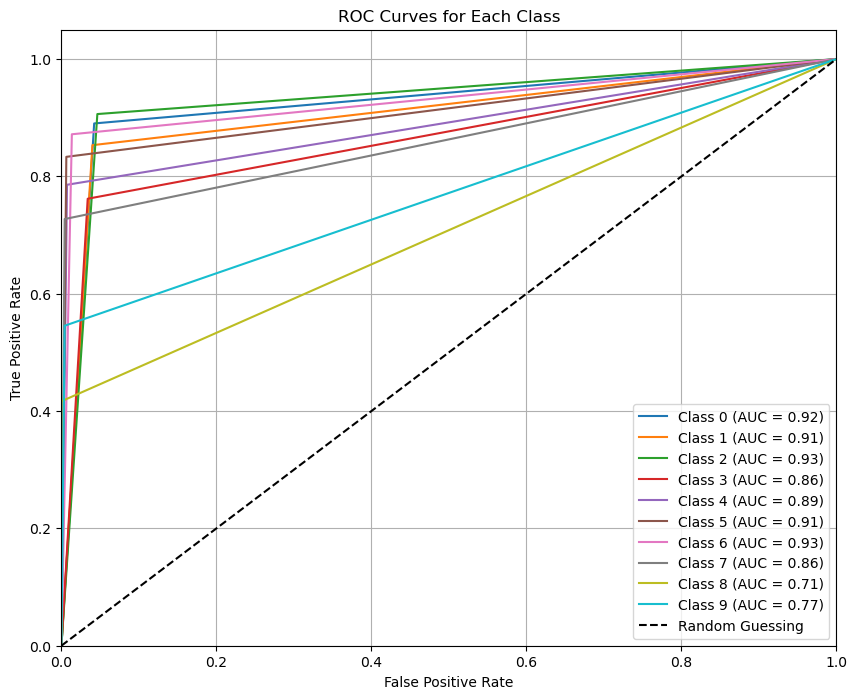

In [48]:
plot_multiclass_roc(true, preds, n_classes=10)

As with the previous models, we can launch a 6-fold cross-validation to make sure the model is robust. The results are represented below :

![Localization CV Results for CNN](locconvcv.png)

Now, let us a try a more complex CNN architecture known as ResNet to see if this model can obtain better performance.

### Model 2 - ResNet

This model works using a series of convolution blocks, which implement a 'shortcut' option. Once treated, the input matrix is added to the treated matrix to form the output of the block. Here, only the model needs to be loaded

In [6]:
class Block(nn.Module):
    def __init__(self, filters, subsample=False):
        super().__init__()
        """
        2-layer residual learning building block
        
        Args
        --- 
        filters:   int
                     the number of filters for all layers in this block
                   
        subsample: boolean
                     whether to subsample the input feature maps with stride 2
                     and doubling in number of filters
                     
        Attributes
        ---
        shortcuts: boolean
                     When false the residual shortcut is removed
                     resulting in a 'plain' convolutional block.
        """
        # Subsampling
        s = 0.5 if subsample else 1.0
        
        # Setup layers
        self.conv1 = nn.Conv1d(int(filters*s), filters, kernel_size=3, 
                               stride=int(1/s), padding=1, bias=False)
        self.bn1   = nn.BatchNorm1d(filters, track_running_stats=True)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(filters, filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm1d(filters, track_running_stats=True)
        self.relu2 = nn.ReLU()

        # Shortcut downsampling
        self.downsample = nn.MaxPool1d(kernel_size=1, stride=2) 
        
    def shortcut(self, z, x):
        """ 
        Shortcut option
        
        Args
        ---
        x: tensor
             the input to the block
        z: tensor
             activations of block prior to final non-linearity
        """
        if x.shape != z.shape:
            d = self.downsample(x)
            p = torch.mul(d, 0)
            return z + torch.cat((d, p), dim=1)
        else:
            return z + x        
    
    def forward(self, x, shortcuts=False):

        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu1(z)
        
        z = self.conv2(z)
        z = self.bn2(z)
        
        # Shortcut connection
        if shortcuts:
            z = self.shortcut(z, x)

        z = self.relu2(z)
        
        return z

In [7]:
class ResNet(nn.Module):
    def __init__(self, shortcuts=True):
        super().__init__()
        self.shortcuts = shortcuts
        
        # Input
        self.convIn = nn.Conv1d(20, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.dropout1 = nn.Dropout(0.3)
        self.bnIn   = nn.BatchNorm1d(16, track_running_stats=True)
        self.relu   = nn.ReLU()

        # Stack2
        self.stack1 = Block(32, subsample=True)

        # Stack3
        self.stack2 = Block(64, subsample=True)
        
        # Output
        self.avgpool = nn.MaxPool1d(kernel_size = 2)
        self.fcOut   = nn.Linear(3200, 10, bias=True)
        self.softmax = nn.LogSoftmax(dim=-1)     
        
        
    def forward(self, x):  

        z = x.permute(0, 2, 1)  # [batch, length, features] --> [batch, features, length]

        z = self.convIn(z)
        z = self.dropout1(z)
        z = self.bnIn(z)
        z = self.relu(z)
        
        # Residual blocks
        z = self.stack1(z, shortcuts=self.shortcuts)
        
        z = self.stack2(z, shortcuts=self.shortcuts)

        z = self.avgpool(z)
        z = z.view(z.size(0), -1)
        z = self.fcOut(z)
        z = self.softmax(z)

        return z

In [8]:
# Print trainable parameters

model = ResNet()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

56426

Now make a new fit function

In [51]:
def fit_resnet_loc(epochs, X_train, y_train, mask_train, X_val, y_val, mask_val, X_test, y_test, mask_test, 
        loss_fn, save_loc, early_stopping = True):
    '''Function to load data and fit model for a set number of epochs and
    a set number of protein embeddings (hence the double for loop).

    Arguments
    ---
    epochs : int
        Number of passes through network
    X_train : array
    y_train : array
    X_val : array
    y_val : array
    X_test : array
    y_test : array
    loss_fn : function
        Loss function to be computed
    save_loc : str
        Where should the results be saved ?
    early_stopping : boolean
        Using early stopping ?

    Returns
    ---
    loss_vectors : list of lists
        Lists of loss values for each epoch
    y_preds : list of lists
        TBC
    '''
    start = time.time()

    # Initialise patience
    if early_stopping:
        print("[INFO]: Initializing early stopping")
        early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0)


    # Create test set.
    loss_vector = []
    val_loss_vector = []
    

    test_dataset = LocalizationCustom(X_test, y_test, mask_test)
    t_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    
    model = ResNet().to(device)

    # Set optimizer based on model parameters
    lr = LR
    optimizer = optim.Adam(model.parameters(), 
                        lr=lr ,amsgrad = False) 

    # Train model for set number of epochs
    for epoch in range(epochs):
        #Create the datasets and dataloaders for training with shuffle each step
        train_data = LocalizationCustom(X_train, y_train, mask_train)
        val_data = LocalizationCustom(X_val, y_val, mask_val)
        train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
        val_loss = validate(model, val_loader, loss_fn, epoch)
        loss_vector.append(train_loss)
        val_loss_vector.append(val_loss)

        if early_stopping:
            early_stopping(val_loss)
            if early_stopping.early_stop:
                break

    test_loss, predictions, real_vals = test(model, t_loader, loss_fn, epochs, '../results')

    # Save weights of each model
    # model_name = f'{path[29:]}_{CURRENT_CV}'
    # save_model(epochs, model, optimizer, loss_fn, save_loc, model_name)
    
    end = time.time()
    
    print(f"Training time: {(end-start)/60:.3f} minutes\n")
    # print(len(predictions_across_embds))
    print("Model complete")
    return loss_vector, val_loss_vector, predictions, real_vals

Launch the training

In [52]:
# Computation device
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {device}\n")

# Set hyperparameters
PATIENCE = 5
BATCH_SIZE = 64
NUM_WORKERS = 0
EPOCHS = 60
LR = 0.001
LOSS_FN = nn.CrossEntropyLoss(reduction = 'none', weight = class_weights) # Include class weights

loss_vector, val_loss_vector, preds, true = fit_resnet_loc(EPOCHS, tx, ty, tm, vx, vy, vm, tex, tey, tem, 
                                   LOSS_FN, None, early_stopping = True)

Computation device: cpu

[INFO]: Initializing early stopping


Epoch 0: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.20batch/s, Train: loss=153.00592]



 Training performance across images : 

Balanced Accuracy Score : 0.19444644919118598
Matthews CC : 0.09461394574484287

 Validation performance across images : 

Balanced Accuracy Score : 0.1
Matthews CC : 0.0


Epoch 1: 100%|████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.45batch/s, Train: loss=100.17936]



 Training performance across images : 

Balanced Accuracy Score : 0.4707191121776094
Matthews CC : 0.3472907177768063

 Validation performance across images : 

Balanced Accuracy Score : 0.19353135732094254
Matthews CC : 0.1860999245279863


Epoch 2: 100%|█████████████████████████████████████████████████| 27/27 [00:02<00:00, 11.96batch/s, Train: loss=69.89108]



 Training performance across images : 

Balanced Accuracy Score : 0.6347626362127186
Matthews CC : 0.5290187377477673

 Validation performance across images : 

Balanced Accuracy Score : 0.4878118996880148
Matthews CC : 0.3740096745141325


Epoch 3: 100%|█████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.01batch/s, Train: loss=47.72344]



 Training performance across images : 

Balanced Accuracy Score : 0.7456142941627008
Matthews CC : 0.6450389862369573

 Validation performance across images : 

Balanced Accuracy Score : 0.6127501779492189
Matthews CC : 0.527302128605424


Epoch 4: 100%|█████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.21batch/s, Train: loss=33.51381]



 Training performance across images : 

Balanced Accuracy Score : 0.8374685181643455
Matthews CC : 0.7378788545261399

 Validation performance across images : 

Balanced Accuracy Score : 0.6545577349229222
Matthews CC : 0.6216376975573322


Epoch 5: 100%|█████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.30batch/s, Train: loss=25.96134]



 Training performance across images : 

Balanced Accuracy Score : 0.8761705079079002
Matthews CC : 0.8111401829487045

 Validation performance across images : 

Balanced Accuracy Score : 0.6491820641982329
Matthews CC : 0.6081205375752278
[INFO]: Early stopping counter - 1 of 5


Epoch 6: 100%|█████████████████████████████████████████████████| 27/27 [00:02<00:00, 11.09batch/s, Train: loss=19.74942]



 Training performance across images : 

Balanced Accuracy Score : 0.9176041312459793
Matthews CC : 0.8577511775841635

 Validation performance across images : 

Balanced Accuracy Score : 0.6661646372468184
Matthews CC : 0.6392765907213663
[INFO]: Early stopping counter - 2 of 5


Epoch 7: 100%|█████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.81batch/s, Train: loss=15.50292]



 Training performance across images : 

Balanced Accuracy Score : 0.936253171173354
Matthews CC : 0.8778260467962369

 Validation performance across images : 

Balanced Accuracy Score : 0.6948731663651379
Matthews CC : 0.7161062859238885


Epoch 8: 100%|█████████████████████████████████████████████████| 27/27 [00:02<00:00, 11.25batch/s, Train: loss=13.77670]



 Training performance across images : 

Balanced Accuracy Score : 0.9430822565950322
Matthews CC : 0.8882397568149712

 Validation performance across images : 

Balanced Accuracy Score : 0.7215364288056081
Matthews CC : 0.7582923579318002


Epoch 9: 100%|█████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.31batch/s, Train: loss=12.64148]



 Training performance across images : 

Balanced Accuracy Score : 0.9478842635210402
Matthews CC : 0.9067244522456895

 Validation performance across images : 

Balanced Accuracy Score : 0.7375049849380804
Matthews CC : 0.7411042230952808


Epoch 10: 100%|█████████████████████████████████████████████████| 27/27 [00:02<00:00, 11.88batch/s, Train: loss=9.62949]



 Training performance across images : 

Balanced Accuracy Score : 0.9659777094314947
Matthews CC : 0.9352531937303362

 Validation performance across images : 

Balanced Accuracy Score : 0.6966904905770873
Matthews CC : 0.7461206820859325
[INFO]: Early stopping counter - 1 of 5


Epoch 11: 100%|█████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.70batch/s, Train: loss=7.52196]



 Training performance across images : 

Balanced Accuracy Score : 0.9746597399629019
Matthews CC : 0.9498499675952399

 Validation performance across images : 

Balanced Accuracy Score : 0.6945960700225864
Matthews CC : 0.7537772950249564
[INFO]: Early stopping counter - 2 of 5


Epoch 12: 100%|█████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.20batch/s, Train: loss=6.94043]



 Training performance across images : 

Balanced Accuracy Score : 0.9778031055127212
Matthews CC : 0.9582115414419866

 Validation performance across images : 

Balanced Accuracy Score : 0.6950094422914449
Matthews CC : 0.7543443681542197
[INFO]: Early stopping counter - 3 of 5


Epoch 13: 100%|█████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.84batch/s, Train: loss=5.82699]



 Training performance across images : 

Balanced Accuracy Score : 0.9806739874465762
Matthews CC : 0.959560521798168

 Validation performance across images : 

Balanced Accuracy Score : 0.7170252198201573
Matthews CC : 0.7642366538204671
[INFO]: Early stopping counter - 4 of 5


Epoch 14: 100%|█████████████████████████████████████████████████| 27/27 [00:02<00:00, 11.17batch/s, Train: loss=4.97434]



 Training performance across images : 

Balanced Accuracy Score : 0.9843767073506051
Matthews CC : 0.9720486168058934

 Validation performance across images : 

Balanced Accuracy Score : 0.7012788846391655
Matthews CC : 0.7594537647716733
[INFO]: Early stopping counter - 5 of 5
[INFO]: Early stopping

 Test performance across images : 

Balanced Accuracy Score : 0.6813250817393243
Matthews CC : 0.7926929740255455
Training time: 0.621 minutes

Model complete


Now plot same metrics

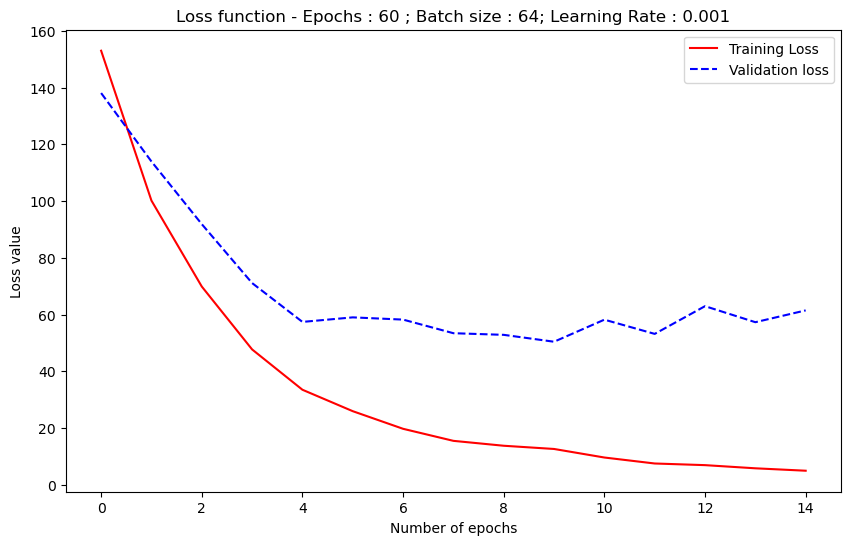

In [53]:
plot_loss_function(loss_vector, val_loss_vector)

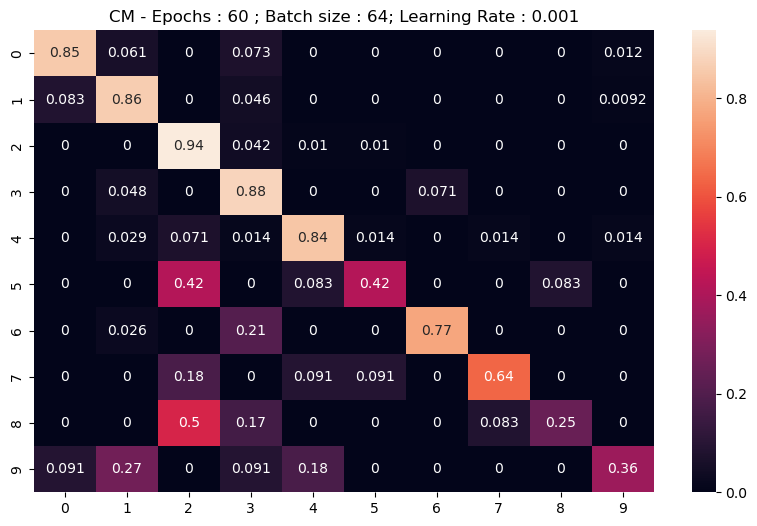

In [54]:
overall_conf_matrix = confusion_matrix(true, preds, normalize='true')

plt.figure(figsize = (10, 6))
sns.heatmap(overall_conf_matrix, annot = True)  
plt.title(f'CM - Epochs : {EPOCHS} ; Batch size : {BATCH_SIZE}; Learning Rate : {LR}')
plt.show()

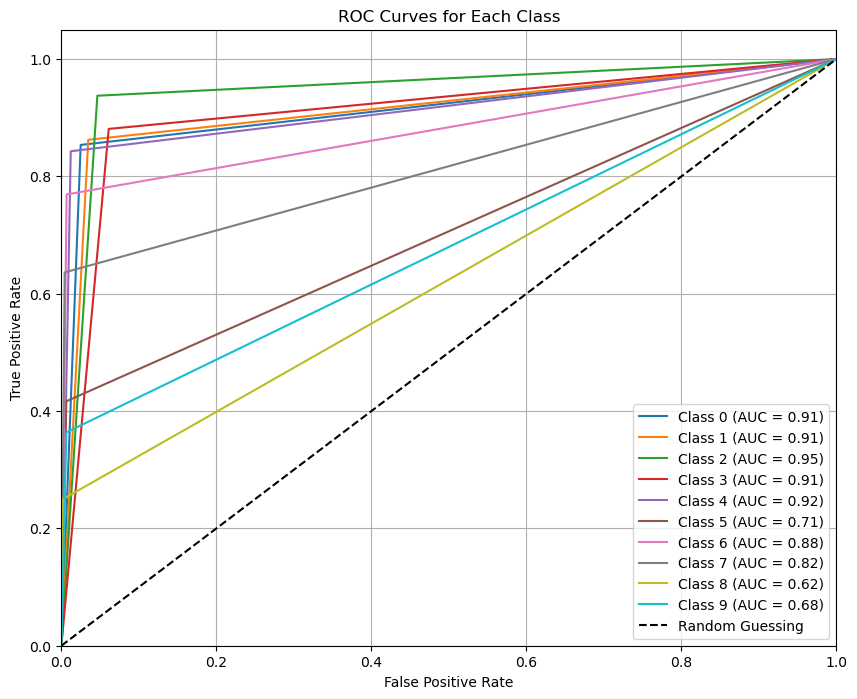

In [55]:
plot_multiclass_roc(true, preds, n_classes=10)

Below are the cross-validation results:

![Localization CV Results for ResNet](locresnetcv.png)

Similarly to the previous models, we can test if there is a significant difference between both these models

In [56]:
# Balanced accuracies for each model across CVs
locconv_ba = [0.75, 0.7, 0.74, 0.76, 0.73, 0.76]
locresnet_ba = [0.67, 0.67, 0.58, 0.66, 0.77, 0.62]

wilcoxon_test(locconv_ba, locresnet_ba)

Wilcoxon p-value : 0.046875


So just about significantly better for the normal convolution than the ResNet (although more cross-validation folds may reinforce the difference in performance between these two models)